## 日本の予備試験と司法試験の問題に回答するタスク（モデルによる比較とファインチューニングによる精度の向上の試み）

### 東北大学の日本語BERTで検証




- 予備試験　民事　Accuracy: 0.15254237288135594
Weighted Accuracy: 0.1376
- 司法試験　民法　Accuracy: 0.18002466091245375
Weighted Accuracy: 0.1722643553629469
- 予備試験　刑事　Accuracy: 0.15636363636363637
Weighted Accuracy: 0.1393939393939394
- 司法試験　刑法　Accuracy: 0.16
Weighted Accuracy: 0.13911290322580644
- 予備試験　公法　Accuracy: 0.07333333333333333
Weighted Accuracy: 0.06832298136645963
- 司法試験　憲法　Accuracy: 0.08888888888888889
Weighted Accuracy: 0.08974358974358974


In [ ]:
! pip install fugashi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
! pip install unidic_lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic_lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658817 sha256=fc4572592d019f6f8e5128c4088d1725c843c78e10219239ddc8eb9a5a8e5cba
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic_lite


In [ ]:
import json
import torch
from transformers import AutoTokenizer, AutoModelForPreTraining


# モデルのロード
def load_model(model_name, device):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForPreTraining.from_pretrained(model_name)
    model.to(device)
    return tokenizer, model

# データセットの読み込み
def load_dataset(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print("ファイルが見つかりません。")
        return None

def predict_question(tokenizer, model, device, question, choices, num_answers):
    max_length = 512
    scores = []

    for choice in choices:
        question = question + "回答："
        input_ids = tokenizer(question, choice, padding=max_length, max_length=max_length, truncation=True, return_tensors="pt")
        input_ids_tensor = input_ids["input_ids"].to(device)
        attention_mask_tensor = input_ids["attention_mask"].to(device)
        outputs = model(input_ids_tensor, attention_mask=attention_mask_tensor)


    # 最もスコアが高い選択肢をnum_answersの数だけ選択
    best_choices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:num_answers]
    return [i + 1 for i in best_choices]  # インデックスを選択肢番号に変換

def calculate_accuracy(y_true, y_pred):
    P = 0  # Positive
    N = 0  # Negative
    for true_answers, pred_answer in zip(y_true, y_pred):
        true_answer_sets = [tuple(map(int, answer.split(','))) for answer in true_answers if answer.strip()]
        pred_answer_tuple = tuple(pred_answer)
        if pred_answer_tuple in true_answer_sets:
            P += 1
        else:
            N += 1
    # Calculating the metrics
    Accuracy = P / (P + N) if (P + N) > 0 else 0
    return Accuracy

def calculate_weighted_accuracy(y_true, y_pred):
    P = 0  # Positive
    N = 0  # Negative
    total_weight = 0

    for true_answers, pred_answer in zip(y_true, y_pred):
        # 正しい構文で true_answer_sets を生成するための例
        true_answer_sets = [tuple(map(int, answer.split(','))) for answer in true_answers if answer.strip()]

        pred_answer_tuple = tuple(pred_answer)
        # 問題の難易度に基づいて重みを設定
        weight = len(true_answer_sets[0])
        if pred_answer_tuple in true_answer_sets:
            P += weight
        else:
            N += weight

        total_weight += weight

    # 重み付き精度の計算
    Weighted_Accuracy = P / total_weight if total_weight > 0 else 0

    return Weighted_Accuracy



# メイン処理
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer, model = load_model("cl-tohoku/bert-base-japanese-v3", device)
    dataset = load_dataset("/content/Bar_examlegal_dataset_2008_to_2022_v6.json")

    if dataset is None:
        return

    y_true, y_pred = [], []

    for year, questions in dataset.items():
        for question in questions:
            if question["options"] != ['None']:
                question_text = question["question_body"]
                choices = question["options"]
                answers = question["answers"]
                num_answers = len(answers[0].split(','))

                predicted = predict_question(tokenizer, model, device, question_text, choices, num_answers)

                y_true.append(answers)
                y_pred.append(predicted)

                # 推論結果の出力
                print(f"質問: {question_text}")
                print(f"選択肢: {choices}")
                print(f"正解: {answers}")
                print(f"予測: {predicted}")
                print("-" * 50)

            else:
                print("選択肢がありません")
                print("-" * 50)

    # Calculate the metrics for provided y_true and y_pred
    accuracy = calculate_accuracy(y_true, y_pred)
    w_accuracy = calculate_weighted_accuracy(y_true, y_pred)
    print("Accuracy:", accuracy)
    print("Weighted Accuracy:", w_accuracy)


if __name__ == "__main__":
    main()


### 早稲田のBigBirdで検証

- 予備試験　民事系
Accuracy: 0.16195856873822975
Weighted Accuracy: 0.1552
- 司法試験　民法　Accuracy: 0.17509247842170161
Weighted Accuracy: 0.1657638136511376
- 予備試験　刑事　Accuracy: 0.1781818181818182
Weighted Accuracy: 0.15454545454545454
- 司法試験　刑法　Accuracy: 0.144
Weighted Accuracy: 0.12096774193548387
- 予備試験　公法　Accuracy: 0.11333333333333333
Weighted Accuracy: 0.10559006211180125
- 予備試験　憲法　Accuracy: 0.08888888888888889
Weighted Accuracy: 0.08547008547008547

In [ ]:
import json
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

# モデルとトークナイザーのロード
def load_model(model_name, device):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForMaskedLM.from_pretrained(model_name)
    model.to(device)
    return tokenizer, model

# データセットの読み込み
def load_dataset(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"ファイルが見つかりません: {filepath}")
        return None

# 質問予測
def predict_question(tokenizer, model, device, question, choices, num_answers):
    scores = []

    model.eval()  # 評価モードに設定
    for choice in choices:
        text_to_encode = question + " 回答：[MASK]"
        input_ids = tokenizer.encode(text_to_encode, return_tensors='pt')
        input_ids = input_ids.to(device)
        mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]

        with torch.no_grad():
            outputs = model(input_ids)
            predictions = outputs.logits
            mask_token_logits = predictions[0, mask_token_index, :]
            mask_token_logits = mask_token_logits.squeeze()

            choice_ids = tokenizer.encode(choice, add_special_tokens=False)
            choice_score = mask_token_logits[choice_ids].mean()  # 選択肢の平均スコア
            scores.append(choice_score)

    best_choices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:num_answers]
    return [i + 1 for i in best_choices]

# 正確度の計算
def calculate_accuracy(y_true, y_pred):
    correct, total = 0, 0
    for true_answers, pred_answer in zip(y_true, y_pred):
        true_answer_sets = [tuple(map(int, answer.split(','))) for answer in true_answers if answer.strip()]
        pred_answer_tuple = tuple(pred_answer)
        if pred_answer_tuple in true_answer_sets:
            correct += 1
        total += 1
    return correct / total if total > 0 else 0

# 重み付き正確度の計算
def calculate_weighted_accuracy(y_true, y_pred):
    correct, total_weight = 0, 0
    for true_answers, pred_answer in zip(y_true, y_pred):
        true_answer_sets = [tuple(map(int, answer.split(','))) for answer in true_answers if answer.strip()]
        pred_answer_tuple = tuple(pred_answer)
        weight = len(true_answer_sets[0])
        if pred_answer_tuple in true_answer_sets:
            correct += weight
        total_weight += weight
    return correct / total_weight if total_weight > 0 else 0

# メイン処理
def main(model_name, dataset_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer, model = load_model(model_name, device)
    dataset = load_dataset(dataset_path)

    if dataset is None:
        return

    y_true, y_pred = [], []
    for year, questions in dataset.items():
        for question in questions:
            if question["options"] != ['None']:
                question_text = question["question_body"]
                choices = question["options"]
                answers = question["answers"]
                num_answers = len(answers[0].split(','))

                predicted = predict_question(tokenizer, model, device, question_text, choices, num_answers)
                y_true.append(answers)
                y_pred.append(predicted)

                print(f"質問: {question_text}")
                print(f"選択肢: {choices}")
                print(f"正解: {answers}")
                print(f"予測: {predicted}")
                print("-" * 50)
            else:
                print("選択肢がありません")
                print("-" * 50)

    accuracy = calculate_accuracy(y_true, y_pred)
    w_accuracy = calculate_weighted_accuracy(y_true, y_pred)
    print("Accuracy:", accuracy)
    print("Weighted Accuracy:", w_accuracy)

if __name__ == "__main__":
    main("nlp-waseda/bigbird-base-japanese", "/content/Bar_examlegal_dataset_2008_to_2022_v6.json")


## 結果一覧

| Model                | Exam Type       |   Accuracy |   Weighted Accuracy |
|:---------------------|:----------------|-----------:|--------------------:|
| 東北大学の日本語BERT | 予備試験 民事   |  0.152542  |           0.1376    |
| 東北大学の日本語BERT | 司法試験 民法   |  0.180025  |           0.172264  |
| 東北大学の日本語BERT | 予備試験 刑事   |  0.156364  |           0.139394  |
| 東北大学の日本語BERT | 司法試験 刑法   |  0.16      |           0.139113  |
| 東北大学の日本語BERT | 予備試験 公法   |  0.0733333 |           0.068323  |
| 東北大学の日本語BERT | 司法試験 憲法   |  0.0888889 |           0.0897436 |
| 早稲田のBigBird      | 予備試験 民事系 |  0.161959  |           0.1552    |
| 早稲田のBigBird      | 司法試験 民法   |  0.175092  |           0.165764  |
| 早稲田のBigBird      | 予備試験 刑事   |  0.178182  |           0.154545  |
| 早稲田のBigBird      | 司法試験 刑法   |  0.144     |           0.120968  |
| 早稲田のBigBird      | 予備試験 公法   |  0.113333  |           0.10559   |
| 早稲田のBigBird      | 予備試験 憲法   |  0.0888889 |           0.0854701 |

考察：ファインチューニングをしないで選択肢の予測を行ったので総じて低い正解率となった。また、公法の正解率が民事系、刑事系よりも低いのは選択肢が ```['１．ア○イ○ウ○', '２．ア○イ○ウ×', '３．ア○イ×ウ○', '４．ア○イ×ウ×', '５．ア×イ○ウ○', '６．ア×イ○ウ×', '７．ア×イ×ウ○', '８．ア×イ×ウ×']```このような複雑な形式だったためと思われる。また、選択肢の数も多いだろう。

改善：とりあえずファインチューニングしてどのくらい精度が上がるのか試してみる。また、選択肢の中の文字が```ア```など人間にはアと問題文中のアを結びつけて考えられるが言語モデルが推測する中でどれほど考慮できているのかわからない。よって、データセットの設計にも課題があると感じた。特に、選択肢については正誤判定の問題が多いため選択肢を入力として、正誤判定をしたほうが良いのかもしれない。一方で、データセットの構築にコストがかかる。

### 東北大のBERTをファインチューニングしてみる

In [ ]:
# データセットの準備
import json
from sklearn.model_selection import train_test_split

# データセットの読み込み
with open('/content/concatenated_data_v6.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# データの変換
X, y = [], [],
for idx, question in enumerate(data):
    text = question["question_body"]
    answers = set(answer.strip() for ans in question["answers"] for answer in ans.split(','))  # 正解の選択肢番号をセットとして取得
    for i, option in enumerate(question["options"]):
        X.append(tuple([text, option]))
        y.append(1 if str(i+1) in answers else 0)  # 選択肢が正解ならTrue、そうでなければFalse

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# トレーニングセットとテストセットのサイズを確認
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

Training set size: 10629, Test set size: 2658


In [ ]:
from transformers import BertJapaneseTokenizer
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-v3')
# データセットの可視化
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams["font.size"] = 18

def visualize_text_length(dataset):
  length_counter = Counter()
  for data in tqdm(dataset):
    length = len(tokenizer.tokenize(data[0]))
    length_counter[length] += 1
  plt.bar(length_counter.keys(), length_counter.values())
  plt.xlabel("Text length")
  plt.ylabel("Number of texts")
  plt.title("Text length distribution")
  plt.show

100%|██████████| 10629/10629 [00:27<00:00, 382.80it/s]


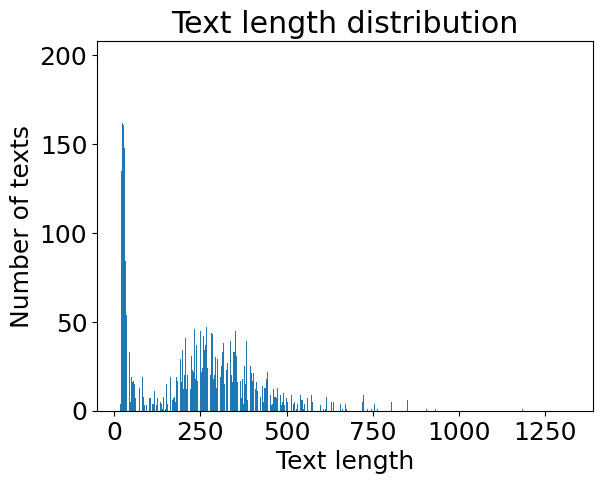

In [ ]:
visualize_text_length(X_train)

In [ ]:
def visualize_labels(dataset):
  label_counter = Counter()
  for data in dataset:
    label_id = data
    label_counter[label_id] += 1

  plt.bar(label_counter.keys(), label_counter.values(), width=1.0)
  plt.ylabel("number of labels")
  plt.xlabel("label")
  plt.show()



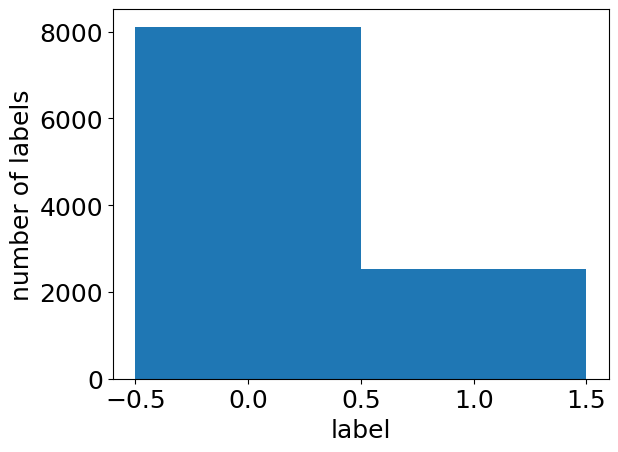

In [ ]:
visualize_labels(y_train)

https://qiita.com/nekoumei/items/7b911c61324f16c43e7e

https://note.com/npaka/n/n49bec37cdd1b

In [1]:
!pip install transformers==4.17 fugashi unidic_lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 29.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 71.7 MB/s eta 0:00:00
  Created wheel for unidic_lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658817 sha256=dbb00dbe8556e426428cb7322758a9a42a38e737f993df55360aee3e94ce0b64
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic_lite
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.6 MB/s eta 0:00:00


In [3]:
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# データセットの準備
import json
from sklearn.model_selection import train_test_split
# データセットの読み込み
with open('/content/concatenated_data_v6.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# データの変換
X, y = [], [],
for idx, question in enumerate(data):
    text = question["question_body"]
    answers = set(answer.strip() for ans in question["answers"] for answer in ans.split(','))  # 正解の選択肢番号をセットとして取得
    for i, option in enumerate(question["options"]):
        X.append(tuple([text, option]))
        y.append(1 if str(i+1) in answers else 0)  # 選択肢が正解ならTrue、そうでなければFalse

# データの分割
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42)
X_eval, X_test, y_eval, y_test = train_test_split(X_eval, y_eval, test_size=0.5, random_state=42)
# トレーニングセットとテストセットのサイズを確認
print(f"Training set size: {len(X_train)}, Eval set saize: {len(X_eval)} Test set size: {len(X_test)}")


Training set size: 9300, Eval set saize: 1993 Test set size: 1994


In [5]:
# Datasetクラスを用意
from torch.utils.data import Dataset
from tqdm import tqdm

class legalQuestionDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
    self.features = [
        {
            "text1": self.X[i][0],
            "text2": self.X[i][1],
            "label": self.y[i]
        } for i in tqdm(range(len(self.X)))
    ]

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.features[idx]

In [6]:
import torch
from transformers import BertJapaneseTokenizer

class LegalQuestionCollator():
    def __init__(self, tokenizer, max_length=512):
      self.tokenizer = tokenizer
      self.tokenizer = tokenizer
      self.max_length = max_length

    def __call__(self, examples):
      print(examples)
      examples = {
          "text1": [example["text1"] for example in examples],
          "text2": [example["text2"] for example in examples],
          "label": torch.tensor([example["label"] for example in examples])
      }
      encodings = self.tokenizer(
          examples["text1"],
          examples["text2"],
          truncation=True,
          max_length=self.max_length,
          padding="max_length",
          return_tensors="pt"
      )
      encodings["labels"] = examples["label"]
      return encodings

tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-v3')
collator = LegalQuestionCollator(tokenizer)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251 [00:00<?, ?B/s]

In [7]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [8]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
%env WANDB_PROJECT=legal_question_classification

env: WANDB_PROJECT=legal_question_classification


In [10]:
#学習
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from accelerate import Accelerator
accelerator = Accelerator()
from transformers import AdamW

model = BertForSequenceClassification.from_pretrained('cl-tohoku/bert-base-japanese-v3')
optimizer = AdamW(model.parameters(), lr=2e-5)
# 既存のモデルとオプティマイザを加速器にラップします
model, optimizer = accelerator.prepare(model, optimizer)

training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    weight_decay=0.01,
    learning_rate=2e-5,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    num_train_epochs=3,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=True,
    hub_model_id="SHONOSUKE/legal_question_classification",
    hub_strategy="every_save",
    logging_dir='./logs',
    report_to="wandb",
    run_name="legal_question_classification"
)

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/427M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v3 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

In [11]:
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [12]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [13]:
# DatasetクラスとCollatorは変更せずにそのまま使用
train_dataset = legalQuestionDataset(X_train, y_train)
eval_dataset = legalQuestionDataset(X_eval, y_eval)

100%|██████████| 1993/1993 [00:00<00:00, 1020665.19it/s]


In [14]:
train_dataset[0]

{'text1': '種類株式発行会社でない株式会社の株主総会に関する次のアからオまでの各記述のうち正しいものを組み合わせたものは後記１から５までのうちどれかア．株式会社が特定の株主から当該株式会社の株式を有償で取得する旨の株主総会の議案について特定の株主に自己をも加えたものとすることを請求した株主は特定の株主以外の株主の全部が当該議案について議決権を行使することができない場合を除き当該議案について議決権を行使することができないイ．取締役会設置会社でない株式会社が当該株式会社の譲渡制限株式の相続人に対し当該譲渡制限株式を当該株式会社に売り渡すことを請求することを議案とする株主総会を招集する場合には当該相続人である株主に対しては当該株主総会の招集の通知を発することを要しないウ．会社法上の公開会社が支配株主の異動を伴う募集株式の発行をする場合において総株主の議決権の１０分の１以上の議決権を有する株主が特定引受人による募集株式の引受けに反対する旨を当該公開会社に対し通知したときは定款に別段の定めがある場合を除き株主総会の特別決議によって当該特定引受人に対する募集株式の割当ての承認を受けなければならないエ．株主総会において議決権を行使することができる株主の数が１０００人以上である株式会社において株主総会に出席しない株主が電磁的方法による議決権の行使をすることができる旨を定めたときは当該株主が書面による議決権の行使をすることができる旨を定めることを要しないオ．吸収合併契約の承認を議案とする株主総会において書面又は電磁的方法による議決権の行使をすることができることとされた株主が株主総会の日の前日までに書面又は電磁的方法によって当該議案に反対する議決権の行使をした場合には当該株主総会に先立って当該吸収合併に反対する旨を株式会社に対し通知したものと認められ反対株主として株式買取請求をすることができる',
 'text2': '１．アエ',
 'label': 0}

In [15]:
# Trainerを初期化する際、acceleratorを使用します
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_accuracy,
    optimizers=(optimizer, None)
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/SHONOSUKE/legal_question_classification into local empty directory.
Using amp half precision backend


In [16]:
trainer.train()

wandb.finish()

[{'text1': '弾劾裁判所に関する次のアからウまでの各記述について正しいものには○誤っているものには×を付した場合の組合せを後記１から８までの中から選びなさいア．弾劾裁判所に対し裁判官の罷免を求める訴追は国会の両議院において当該裁判官の罷免を求める議案が可決されることにより国会が行うイ．国会の両議院の議員で組織される弾劾裁判所は国会が閉会中であっても活動することができるウ．弾劾裁判所により罷免の裁判の宣告を受けた裁判官は最高裁判所に対しその裁判を不服として取消しを求めることができる', 'text2': '５．ア×イ○ウ○', 'label': 0}, {'text1': '催告に関する次のアからオまでの各記述のうち誤っているものを組み合わせたものは後記１から５までのうちどれかア．被保佐人との間で不動産の売買契約を締結した者が保佐人に対し１か月以上の期間を定めてその期間内にその売買契約を追認するかどうかを確答すべき旨の催告をし保佐人がその期間内に確答を発しなかった場合にはその売買契約を追認したものとみなされるイ．無権代理人がした売買契約についてその売買契約の相手方が本人に対し相当の期間を定めてその期間内にその売買契約を追認するかどうかを確答すべき旨の催告をし本人がその期間内に確答をしなかった場合にはその売買契約を追認したものとみなされるウ．債権者があらかじめ弁済の受領を拒んでいるときは債務者は弁済の準備をしたことを通知してその受領の催告をすれば債務不履行責任を免れるエ．債務不履行に基づく解除権が発生した場合その相手方が解除権を有する者に対し相当の期間を定めてその期間内に解除をするかどうかを確答すべき旨の催告をしその期間内に解除の通知を受けなかったときは解除権は消滅するオ．遺贈義務者が受遺者に対し相当の期間を定めてその期間内にその遺贈の承認又は放棄をすべき旨の催告をし受遺者がその期間内に遺贈義務者に対してその意思を表示しなかった場合にはその遺贈を放棄したものとみなされる', 'text2': '３．イオ', 'label': 1}, {'text1': '債権の目的に関する次のアからオまでの各記述のうち正しいものを組み合わせたものは後記１から５までのうちどれかア．特定物の引渡しを目的とする債権の債務者はその引渡しをするまで自己の財産に対するのと同一の注意をもっ

Epoch,Training Loss,Validation Loss,Accuracy
1,0.528600,0.495159,0.794782
2,0.496200,0.490906,0.794782
3,0.484700,0.489039,0.794782


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': 'ＡはＢのためにＡがＣに対して有する指名債権である金銭債権を目的として質権を設定しＣに対して質権の設定を通知したこの事例に関する次の１から５までの各記述のうち誤っているものはどれか', 'text2': '２．Ａは第三者に対して目的債権を譲渡することができない', 'label': 1}, {'text1': '詐害行為取消権に関する次のアからオまでの各記述のうち判例の趣旨に照らし正しいものを組み合わせたものは後記１から５までのうちどれかア．共同相続人間で成立した遺産分割協議は詐害行為取消権の対象とならないイ．詐害行為取消権が成立するためには債務者が債権者を害することを意図して法律行為をする必要があるウ．債務超過の状態にある者が離婚に伴う財産分与として配偶者に金銭の給付をする旨の合意はその額が財産分与として不相当に過大で財産分与に仮託された財産処分と認められる事情がある場合不相当に過大な部分についてその限度において詐害行為として取り消すことができるエ．抵当権が設定されている一個の建物をその抵当権者に代物弁済として供した債務者の行為が詐害行為となる場合他の一般債権者は当該建物の価額から当該抵当権の被担保債権額を控除した残額の範囲で取り消すことができその限度において価額の賠償を請求することが許されるにとどまり当該建物自体を債務者の一般財産として回復することはできないオ．詐害行為取消権は訴訟において行使しなければならないが訴えによる必要はなく抗弁によって行使することもできる', 'text2': '１．アイ', 'label': 0}, {'text1': 'ＡがＢに対し振り出した約束手形に関する次の１から５までの各記述のうち誤っているものを２個選びなさいなお支払拒絶証書の作成は免除されているものとする', 'text2': '４．Ｂから裏書を受けたＣはＡに対し支払呈示期間経過後に支払のため手形を呈示した場合であっても満期日からの遅延損害金を請求することができる', 'label': 1}, {'text1': '株式に関する次のアからオまでの各記述のうち判例の趣旨に照らし正しいものを組み合わせたものは後記１から５までのうちどれかア．他人の承諾を得てその名義を用いて募集株式の引受けがされた場合には特段の事情がない限りその名義の使用を承諾した者が株主と

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '取締役に関する次のアからオまでの各記述のうち誤っているものを組み合わせたものは後記１から５までのうちどれかア.親会社の代表取締役はその子会社である株式会社の社外取締役となることができないイ.取締役の報酬として金銭でないものについてその具体的な内容を定める議案を株主総会に提出した取締役は当該株主総会において当該内容を相当とする理由を説明しなければならないウ.委員会設置会社でない会社法上の公開会社の取締役の任期は選任後２年以内に終了する事業年度のうち最終のものに関する定時株主総会の終結の時までであり定款又は株主総会の決議によってその任期を短縮することはできるがこれを伸長することはできないエ.取締役を解任する株主総会の決議は定款に別段の定めがない限り議決権を行使することができる株主の議決権の過半数を有する株主が出席し出席した当該株主の議決権の３分の２以上に当たる多数をもって行わなければならないオ.株主総会の決議により取締役が解任された場合において当該決議に取消事由が存するときは当該決議の取消しにより取締役となる者は当該決議の日から３か月以内に訴えをもって当該決議の取消しを請求することができる', 'text2': '５.ウオ', 'label': 0}, {'text1': '次のアからオまでの各事項のうちその可否が刑事訴訟法の規定上法定刑の軽重により異ならないものの組合せは後記１から５までのうちどれかア．緊急逮捕イ．必要的保釈権利保釈ウ．勾留の執行停止エ．検察官による第１回公判期日前の証人尋問請求オ．即決裁判手続の申立て', 'text2': '２．アオ', 'label': 0}, {'text1': '(配点：２法の下の平等に関する次のアからウまでの各記述について判例の趣旨に照らして正しいものには○誤っているものには×を付した場合の組合せを後記１から８までの中から選びなさい｡ア．憲法は外国人を日本国民と全く平等に扱うことまでは要求していないが我が国に入国する全ての外国人に対し法律により日本国民と異なる規制を設けることは人種的な差別をする趣旨ではなくても憲法第１４条第１項後段の「人種」による差別として許されないイ．選挙権の平等には各選挙人の投票価値の平等も含まれるが国会によって定められた選挙制度における投票価値が不平等であってもその不平等が国会

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '訴えの利益に関する次のアからウまでの各記述について最高裁判所の判例の趣旨に照らし正しいものに○誤っているものに×を付した場合の組合せを後記１から８までの中から選びなさいア．町営土地改良事業の施行認可処分の取消しを求める訴訟の係属中に事業計画に係る工事及び換地処分がすべて完了したため社会通念上事業施行以前の原状に回復することが不可能になったとしても認可処分の取消しを求める訴えの利益は消滅しないイ．退去強制令書の送還部分が執行され被処分者が強制送還されてしまえば処分はその目的を達成し被処分者の退去義務は消滅するが退去を強制された者の本邦への上陸拒否期間が経過するまでは退去強制令書発付処分の取消しを求める訴えの利益は消滅しないウ．都市計画法第２９条に基づく開発許可の取消しを求める訴訟の係属中に許可を受けた開発行為に関する工事が完了し検査済証が交付されたとしても当該開発許可が判決で取り消された場合には違法な開発行為であることが公権的に確定されその拘束力により都道府県知事等は同法第８１条に基づく違反是正命令を発すべき義務を負うことになるから開発許可の取消しを求める訴えの利益は消滅しない', 'text2': '６．ア×イ○ウ×', 'label': 0}, {'text1': '次のⅠ及びⅡの【見解】は常習一罪などの実体法上一罪の関係にある数個の可罰的行為についての勾留の効力に関する考え方を述べたものであるこれらの【見解】のいずれかを前提に後記【事例】における権利保釈の除外事由に関する判断について述べた後記アからカまでの【記述】のうち正しいものの組合せは後記１から５までのうちどれか【見解】Ⅰ.一罪の一部を構成する可罰的行為についての勾留の効力は起訴の有無にかかわらず当然に他の部分に及ぶⅡ.一罪の一部を構成する可罰的行為についての勾留の効力は起訴の有無にかかわらず他の部分に及ばない【事例】甲は平成○○年３月１０日ａ事件に甲が経理係長として勤務する株式会社Ｖ所有の現金１００万円を横領したという業務上横領事件で同年５月１日逮捕され引き続き勾留された上勾留中のまま起訴された甲には同年３月１２日ｂ事件と同年４月１５日ｃ事件に同様に株式会社Ｖ所有の現金各２００万円を横領したという業務上横領の余罪がありこれらの事件はいまだ起訴されていないａ事件の第一回公判期日前であ

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '正当防衛に関する次の１から５までの各記述を判例の立場に従って検討した場合正しいものを２個選びなさい', 'text2': '４．自己に対しナイフを示して脅している相手方に対し専ら攻撃の意思で暴行に及んだ場合その暴行行為については正当防衛が成立する余地はない', 'label': 1}, {'text1': '次の学生ＡないしＤの【会話】は医師が捜査機関の依頼に基づき人の身体から注射器を用いて直接強制により血液を採取するために必要と考えられる令状に関する議論である学生ＡないしＤが必要と考えている令状として正しい組合せは後記１から５までのうちどれか【会話】学生Ａ：私は一般に身体内にある体液を採取するために必要な令状については強制採尿に関する判例が採用した考え方と同じでよいと思う学生Ｂ：しかし同じ体液といっても尿と血液とでは性質が全然違うからなあ学生Ｃ：そういうＢさんの見解も対象者が採血を拒否した場合には直接強制するための明文がないのが問題だ学生Ｂ：その点は刑事訴訟法第１７２条の類推適用で対応できると思う学生Ｄ：Ｃさんの見解だってもともとその令状が想定している範囲は身体の外表かせいぜい肛門等の体腔を外部から確認する程度であって身体の損傷を伴う血液の採取をその令状で行い得るとするのは行き過ぎだ学生Ｃ：そういうＤさんの見解もそれぞれの令状が単独ではできないことを令状を併用すればできるとするのは便宜に過ぎるのではないかと批判されているよね学生Ｄ：でもＢさんの見解のように直接の明文規定を欠いているにもかかわらず条文の類推適用によって直接強制し得るとするよりは良いと思う', 'text2': '２．Ａ：捜索差押許可状Ｂ：身体検査令状Ｃ：鑑定処分許可状Ｄ：鑑定処分許可状及び身体検査令状', 'label': 0}, {'text1': '次の【事例】における証人尋問について述べた後記アからオまでの【記述】のうち正しいものの組合せは後記１から５までのうちどれか【事例】検察官は甲に対する傷害被疑事件の捜査において目撃者Ｗを取り調べて供述録取書以下「検察官調書」というを作成した上甲を傷害罪で地方裁判所に起訴した検察官は公判において検察官調書の取調べを請求したが弁護人はこれを証拠とすることに同意しなかったそこで検察官はＷの証人尋問を請求した裁判所はＷが病気で入院してい

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '正当防衛に関する次の１から５までの各記述を判例の立場に従って検討した場合正しいものはどれか', 'text2': '３．相手方を挑発して相手方による侵害を自ら招いた者がそれに対し反撃した場合正当防衛が成立する余地はない', 'label': 1}, {'text1': '物権変動に関する次のアからオまでの各記述のうち判例の趣旨に照らし正しいものを組み合わせたものは後記１から５までのうちどれかNo.７ア．Ａはその所有する甲土地上にＢのために第一順位の抵当権をＣのために第二順位の抵当権をそれぞれ設定しその登記がされたその後Ｃが甲土地をＡから相続によって取得した場合であっても第二順位の抵当権は混同により消滅しないイ．Ａがその所有する甲土地をＢに売却した後Ｂが甲土地をＣに転売しそれぞれその旨の登記がされたその後Ａは詐欺を理由としてＢとの売買契約を取り消したＣはＡの売買の意思表示が詐欺によることを過失なく知らなかった場合甲土地の所有権の取得を妨げられないウ．ＡとＢが甲建物及びその敷地である乙土地をそれぞれ共有していたところ乙土地のＡの共有持分に抵当権が設定されたその後その抵当権が実行されＣがそれを買い受けた場合甲建物のために乙土地上に地上権が成立するエ．Ａがその所有する甲土地をＢに売却した後Ｂが甲土地をＣに転売しそれぞれその旨の登記がされたその後ＡとＢとの間の売買契約はＡが成年被後見人であることを理由として取り消されたＣがＡが成年被後見人であったことを過失なく知らなかった場合ＡはＣに対し甲土地の所有権が自己にあることを主張することができないオ．地役権の要役地の所有権を単独で相続した者は地役権設定行為に別段の定めがないときはその土地の地役権も相続する', 'text2': '２．アエ', 'label': 0}, {'text1': '次の１から５までの各記述を判例の立場に従って検討した場合正しいものはどれか', 'text2': '２．法人事業主を両罰規定により処罰するためには現実に犯罪行為を行った従業者も処罰されなければならない', 'label': 0}, {'text1': '共有に関する次のアからオまでの各記述のうち判例の趣旨に照らし正しいものを組み合わせたものは後記１から５までのうちどれかア．共有者全員が賃貸人となり共有物を目的とする賃貸借契

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '次のアからオまでの各記述を判例の立場に従って検討した場合甲に乙又は乙社に対する脅迫罪が成立するものの組合せは後記１から７までのうちどれかア．甲は乙に対し乙の妻の実兄である丙を殺害する旨告知し乙は丙が殺されるかもしれない旨畏怖したイ．甲は乙株式会社総務課長丙に対して乙社の商品不買運動を行って乙社の営業活動を妨害する旨告知し丙は乙社の営業活動が妨害されるかもしれない旨畏怖したウ．甲はインターネット上の掲示板に乙が匿名で行った書き込みに対し同掲示板に「そんな投稿をするやつには天罰が下る」旨の書き込みを行いこれを閲読した乙は小心者だったことから何か悪いことが起こるかもしれない旨畏怖したエ．甲は口論の末乙に対し「ぶっ殺すぞ」と怒号したこの様子を見ていた周囲の人たちは甲が本当に乙を殺害するのではないかと恐れたが乙は剛胆であったため畏怖しなかったオ．甲は単身生活の乙に対し「乙宅を爆破する」旨記載した手紙を投函し同手紙は乙方に配達されたが同手紙には差出人が記載されていなかったことから不審に思った乙は同手紙を開封しないまま廃棄した', 'text2': '２．アウ', 'label': 0}, {'text1': '告訴の効力に関する次のアからエまでの各記述のうち正しいものの組合せは後記１から５までのうちどれかア.Ｖは自己の所有する自転車が損壊されたとして甲を器物損壊の罪で告訴した捜査の結果真犯人は乙であり甲は事件と無関係であることが判明したこの場合Ｖの告訴の効力は乙に対して及ぶイ.Ｖ１は月刊誌に自己の名誉を毀損する記事が掲載されたとして同月刊誌の編集責任者甲を名誉毀損の罪で告訴した捜査の結果甲に前記記事によるＶ１及びその愛人Ｖ２に対する名誉毀損の事実が認められた場合Ｖ１の告訴の効力は甲のＶ２に対する名誉毀損の事実にも及ぶウ.Ｖは甲から住居侵入及びこれと科刑上一罪の関係にある強制わいせつの被害を受けたが甲を住居侵入の罪に限定して告訴したこの場合Ｖの告訴の効力は強制わいせつの事実には及ばないエ.Ｖは自宅から自己の所有する宝石が盗まれたとして親族でない甲を窃盗の罪で告訴した捜査の結果甲がＶの別居中の弟乙とともに窃盗に及んだことが判明した場合Ｖの告訴の効力は乙に対しても及ぶ', 'text2': '４.イエ', 'label': 0}, {'text1': '次の【

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '株主総会の招集及び株主提案権に関する次のアからオまでの各記述のうち正しいものを組み合わせたものは後記１から５までのうちどれかア．株主が取締役に対し適法に株主総会の招集を請求したにもかかわらず遅滞なく招集の手続が行われない場合にはその株主は裁判所の許可を得て自ら株主総会を招集することができるイ．会社法上の公開会社は株主が取締役に対し一定の事項を株主総会の議題とすることを請求するためにはその請求は株主総会の日の３か月前までにしなければならない旨を定款で定めることができるウ．取締役の選任に関する議案に限り株主総会において議決権を行使することができる旨の定款の定めがある議決権制限株式の株主は取締役に対し剰余金の配当を株主総会の議題とすることを請求することができないエ．特定の議案につき株主総会において会社法所定の議決権の割合以上の賛成を得られなかった場合にはその日から５年を経過しない限り株主は株主総会においてその議案と実質的に同一の議案を提出することができないオ．会社は総株主の議決権の１００分の１以上の議決権を有する株主の同意がある場合に限り株主総会に係る招集の手続及び決議の方法を調査させるためその株主総会に先立ち裁判所に対し検査役の選任の申立てをすることができる', 'text2': '５．ウオ', 'label': 0}, {'text1': '訴訟上の合意に関する次の１から５までの各記述のうち判例の趣旨に照らし誤っているものはどれか', 'text2': '４．裁判外で訴えを取り下げる旨の合意が成立し被告がその存在を主張立証した場合には裁判所は当該訴えを却下しなければならない', 'label': 0}, {'text1': '普通地方公共団体であるＡ市においては公金の支出を内容とする特定の処分をする権限が市長から総務部長に委任されていたこのような場合においてＡ市の住民Ｘが地方自治法以下「法」という第２４２条の２第１項の規定に基づいて提起する住民訴訟における被告とすべき者他の訴訟要件については問題はないものとするに関する次のアからエまでの各記述についてそれぞれ正しい場合には１を誤っている場合には２を選びなさいアからエの順にからア．問題とされる処分がされることが相当の確実さをもって予測される事例においてＸは総務部長Ｂを被告として法第２４２条の２第１

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '保証に関する次のアからオまでの各記述のうち判例の趣旨に照らし正しいものを組み合わせたものは後記１から５までのうちどれかア．不動産の売買契約における売主の債務を保証することはできないイ．貸金等根保証契約においては元本の確定期日を定めた場合であっても極度額を定めなければその効力を生じないウ．身元保証人たる地位は身元保証人が死亡した場合には相続されないエ．賃貸借契約において賃借人が賃貸人に対して負う債務を期間の定めなく保証した保証人は保証契約の成立後相当の期間が経過したときは保証契約を将来に向けて解約することができるオ．賃貸借契約において賃借人が賃貸人に対して負う債務を期間の定めなく保証した保証人は賃貸借契約の存続期間中に賃借人が死亡しその相続人が賃貸借契約上の地位を承継したときはその承継後に生じた賃借人の債務につき責めを負わない', 'text2': '５．エオ', 'label': 0}, {'text1': '更改及び混同に関する次のアからオまでの各記述のうち判例の趣旨に照らし誤っているものを組み合わせたものは後記１から５までのうちどれかア．消費貸借契約の成立後第三者が借主と連帯して債務弁済の責任を負担することを約することは更改に当たるイ．債権者の交替による更改は確定日付のある証書によってしなければ第三者に対抗することができないウ．保証人が主たる債務者を単独で相続した場合保証債務を担保するために抵当権が設定されているときは保証債務は消滅しないエ．更改の当事者は更改前の債務の目的の限度であればその債務の担保として第三者が設定した抵当権をその第三者の承諾を得ずに更改後の債務に移すことができるオ．Ａが所有する甲建物の賃借人ＢがＡから甲建物を譲り受けて占有を継続していたがＣがＡから甲建物を譲り受けその旨の所有権移転登記を経由したためＢにおいて甲建物の所有権の取得をＣに対抗することができなくなったときは賃借権はＣに対する関係で消滅しなかったものとなる', 'text2': '４．イオ', 'label': 0}, {'text1': '刑罰論に関する次の各【見解】についての後記１から５までの各【記述】のうち誤っているものを２個選びなさい【見解】Ａ．刑罰の目的は行為者が将来再び犯罪を行うのを予防することにあるＢ．刑罰の目的は刑罰による威嚇を通して一般人が

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '約束手形に関する次のアからオまでの各記述のうち誤っているものを組み合わせたものは後記１から５までのうちどれかア．全国銀行協会が規格・様式を定めた統一手形用紙によらないで振り出された約束手形も有効であるイ．振出人が第三者の住所で支払うべき旨が記載されている約束手形も有効であるウ．約束手形の金額として数字で二つの金額が記載されている場合においてそれら二つの金額に差異があるときは当該約束手形は無効であるエ．判例の趣旨によれば振出日として記載された日よりも前の日が満期として記載されている確定日払いの約束手形は無効であるオ．判例の趣旨によれば暦に存在しない平年における２月２９日が満期として記載されている約束手形は無効である', 'text2': '１．アイ', 'label': 0}, {'text1': 'ＡがＢに賃貸しているＡ所有の甲建物にＣのための抵当権が設定されその登記がされているこの場合における抵当権に基づくＣの物上代位権の行使に関する次のアからオまでの各記述のうち判例の趣旨に照らし誤っているものを組み合わせたものは後記１から５までのうちどれかNo.11ア．Ｃのための抵当権の設定登記がされた後にＢがＡに対して金銭を貸し付けその貸金債権の弁済期が到来した場合ＡのＢに対する賃料債権についてＣが物上代位権を行使して差押えをした後であってもＢはＡに対する貸金債権を自働債権としＡの賃料債権を受働債権とする相殺をもってＣに対抗することができるイ．ＡのＢに対する賃料債権についてＣが物上代位権を行使して差押えをした場合においてＢがＣに賃料を支払わないままＡＢ間の賃貸借契約が終了しＢが甲建物をＡに明け渡したこの場合においてＢがＡにあらかじめ敷金を預託していたときはＣが差し押さえた賃料債権は敷金の充当によりその限度で消滅するウ．Ｂが甲建物をＤに転貸した場合ＣはＢをＡと同視することが相当であるときを除きＢのＤに対する転貸賃料債権について物上代位権を行使することができるエ．ＡのＢに対する賃料債権をＡの一般債権者Ｅが差し押さえて転付命令を取得しその転付命令がＢに送達された後はＣは同一の債権を差し押さえて物上代位権を行使してＥに対抗することができないオ．ＡのＢに対する賃料債権をＡの一般債権者Ｅが差し押さえその差押命令がＢに送達された後にＡがＣのために甲建物に抵当権を設定

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '種類株式発行会社でない会社法上の公開会社における新株発行の無効の訴えに係る無効原因に関する次のアからオまでの各記述のうち判例の趣旨に照らし誤っているものを組み合わせたものは後記１から５までのうちどれかア．募集株式を引き受ける者に特に有利な払込金額による募集株式の発行が株主総会の特別決議を経ないでされたことは無効原因とならないイ．募集事項の株主に対する通知又は公告のいずれも欠いたことは無効原因とならないウ．募集株式の発行が著しく不公正な方法によってされたことは無効原因とならないエ．募集株式の発行に必要とされる取締役会の決議を経ていないことは無効原因とならないオ．募集株式の発行差止請求訴訟を本案とする募集株式の発行の差止めの仮処分命令があるにもかかわらずその仮処分命令に違反して募集株式の発行がされたことは無効原因とならない', 'text2': '５．ウオ', 'label': 0}, {'text1': '過失相殺及び損益相殺に関する次のアからオまでの各記述のうち判例の趣旨に照らし正しいものを組み合わせたものは後記１から５までのうちどれかア．被害者の過失を考慮するためには被害者に自己の行為の責任を弁識するに足りる知能が備わっていることを要するイ．内縁の夫が運転する自動車に同乗していた者が内縁の夫と第三者の双方の過失による交通事故で負傷し第三者に対し損害賠償を請求する場合において裁判所は損害賠償の額を定めるに当たり内縁の夫の過失を被害者側の過失として考慮することはできないウ．複数の加害者の過失及び被害者の過失が競合する一つの交通事故においてその交通事故の原因となった全ての過失の割合いわゆる絶対的過失割合を認定することができるときには絶対的過失割合に基づく被害者の過失による過失相殺をした損害賠償額について加害者らは連帯して共同不法行為に基づく賠償責任を負うエ．被害者に対する加害行為と加害行為前から存在した被害者の疾患とが共に原因となって損害が発生した場合において当該疾患の態様程度などに照らし加害者に損害の全部を賠償させるのが公平を失するときは裁判所は損害賠償の額を定めるに当たり過失相殺の規定を類推適用して被害者の疾患を考慮することができるオ．不法行為により死亡した被害者の相続人が加害者に対し不法行為に基づく損害賠償を請求した場合裁判所は生命保険契約

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '次のアからオまでの各記述における甲の罪責について判例の立場に従って検討した場合正しいものの組合せは後記１から５までのうちどれかア．甲が自然湖の一部に設けられた乙のいけすから逃げ出した乙所有の錦鯉３０匹を同湖内の同いけすから離れた場所で発見し乙が所有する錦鯉であると認識しながらこれらを自己のものにしようと考えて捕獲した場合窃盗罪が成立するイ．甲はパチスロ機に針金を差し込んで誤作動させてメダルを窃取することを乙と共謀し乙による窃盗の犯行を周囲から見えにくくするため乙の隣のパチスロ機で通常の遊戯を行いそれによりメダルを取得したこの場合甲自身が遊戯したパチスロ機で取得したメダルについても窃盗罪が成立するウ．甲が乙から封かんされた現金２０万円入りの封筒を渡されてそれを丙に届けるように依頼されたが丙方に向かう途中で封筒内の現金が欲しくなり封を開いて封筒に入っていた現金のうち５万円を取り出してこれを自己のものとし残りの現金が入った封筒を丙に交付した場合取り出した５万円について窃盗罪が成立するエ．甲は乙から乙が海中に落とした腕時計の引き揚げを依頼されその腕時計が落ちた場所の大体の位置を指示された甲が乙から指示された海中付近を探索した結果同腕時計を発見したがそれを乙に知らせることなく同腕時計を引き揚げて自己のものとした場合窃盗罪が成立するオ．甲が満員電車に乗っていた際隣の席に座っていた見ず知らずの乙が財布を座席に置き忘れたままＸ駅で下車したのを目撃し乙の財布とその中身を自己のものにしようと考え次のＹ駅に到着した時点で乙の財布を取得した上同駅で下車し自宅に持ち帰った場合窃盗罪が成立する', 'text2': '４．ウエ', 'label': 1}, {'text1': '国政調査権に関する次のアからウまでの各記述について正しいものには〇誤っているものには×を付した場合の組み合わせを後記１から８までの中から選びなさいNo.20ア．憲法第６２条において議院は国政調査に関して証人の出頭証言及び記録の提出を要求することができるとされているところその実効性を担保するため法律は証人が正当な理由なく出頭を拒否した場合や偽証した場合に刑罰を科す旨を定めているイ．議院が係属中の刑事事件において審理されている事実と同一の事実について調査することはその調査の方法目的を問わず司法権の独

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': 'Ａ男とＢ女の間の内縁関係に関する次のアからオまでの各記述のうち判例の趣旨に照らし正しいものを組み合わせたものは後記１から５までのうちどれかア．ＡがＢに無断で婚姻届を作成して提出した場合その当時両名に夫婦としての実質的生活関係が存在しかつ後にＢが届出の事実を知ってこれを追認したときはその婚姻は追認により届出の当初にさかのぼって有効となるイ．Ａが内縁関係を正当な理由なく一方的に破棄した場合ＢはＡに対し債務不履行を理由として損害賠償を請求することができるが不法行為を理由として損害賠償を請求することはできないウ．Ｂが内縁継続中に病気療養のためＡと別居している場合においてその間にＢが支出した医療費は婚姻から生ずる費用に準じてＡＢが分担するエ．内縁成立の日から２００日を経過した後又は内縁解消の日から３００日以内にＢが分娩した子のＡに対する認知の訴えにおいてはその子はＡの子と推定されないオ．ＢはＡが死亡したときの相続についてＡと他の女性との間の子であるＣに対しＡの配偶者に準ずる相続分を主張することができる', 'text2': '１．アイ', 'label': 0}, {'text1': '行政指導に関する次のアからウまでの各記述について正しいものに○誤っているものに×を付した場合の組合せを後記１から８までの中から選びなさいア．行政指導は相手方の任意の協力によって一定の行政目的を実現するものであって法律にその具体的根拠規定がない場合に行われるものであるイ．行政指導とは指導勧告助言その他の行為であって処分に該当しないものをいうから行政指導が国家賠償法第１条第１項にいう「公権力の行使」に当たることはないウ．法律に許可の条件に違反した場合には許可を取り消すことができるとの規定がある場合に許可を受けた相手方が条件に違反する行為をしていることが明らかとなったため処分行政庁は条件違反の是正を求める行政指導をしたところが相手方はこれに従う意思のない旨を表明したため処分行政庁は許可を取り消したこの場合の許可の取消しは行政指導に従わなかったことを理由とする不利益な取扱いには当たらない', 'text2': '３．ア○イ×ウ○', 'label': 0}, {'text1': '用益物権に関する次の１から５までの各記述のうち判例の趣旨に照らし誤っているものはどれか', 'te

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '次のアからエまでの各事例におけるＸが行政事件訴訟法上の仮の救済を求めるとした場合各事例について最も適切と考えられる仮の救済の申立てをそれぞれ後記１から３までの中から選びなさいアからエの順にからア．タクシー会社であるＸが道路運送法に基づき運賃及び料金の認可申請をしたところ処分行政庁から申請を拒否する処分を受けた事例イ．県知事が公有水面埋立法に基づき公有水面埋立免許を与えた後に当該免許に基づく工事により周辺の景観が破壊されることを危惧する周辺住民Ｘの事例ウ．地方公務員であるＸが非行があったとして懲戒権者から地方公務員法に基づき停職処分をされようとしている事例エ．市の公園で集会を開催しようと計画していたＸが当該市の条例に基づき公園の使用許可を市長に申請し使用許可を受けたがその後集会の開催前に集会内容が不適切であるとして市長から当該使用許可を取り消す処分を受けた事例', 'text2': '１．執行停止の申立て', 'label': 1}, {'text1': '申立事項と判決事項に関する次のアからオまでの各記述のうち判例の趣旨に照らし正しいものを組み合わせたものは後記１から５までのうちどれかア．原告が提起した貸金１０００万円の返還を求める訴えについて弁済期の未到来のため給付判決をすることができない場合には原告が訴えを変更しないときであっても裁判所はこれに代えて１０００万円の貸金債権の存在を確認する判決をすることができるイ．原告が平成２０年９月２５日に貸し付けた１０００万円の貸金の返還を求める訴訟において審理の結果被告がその貸金を返還したものの同年１２月１４日に原告が貸し付けた２０００万円の貸金はまだ返還していないことが明らかになったときは裁判所は原告が求めた１０００万円の支払の限度で請求を認容する判決をすることができるウ．原告が提起した不動産の所有権に基づく所有権移転登記の全部抹消登記手続を求める訴えについて裁判所はその不動産が原告及び被告の共有関係にあると認めたときは実質的な一部抹消登記手続として原告の共有持分に応じた更正登記手続を命じる判決をすることができるエ．５０万円を超えて貸金債務が存在しないことの確認を求める訴えについて裁判所は５０万円を超えて債務が存在すると認めた場合には貸金残額の存否ないしその限度を明確に判断することなく直ちに請求を棄

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '自白及びその撤回に関する次のアからオまでの各記述のうち判例の趣旨に照らし正しいものは幾つあるか後記１から５までのうちから選びなさいア．当事者が証拠として提出した契約書について相手方がその成立の真正を認める旨の陳述をした場合には裁判所は証拠によっても当該契約書の成立の真正を否定することができないイ．口頭弁論の期日において相手方の主張した事実を争うことを明らかにしなかった当事者は次回以降の期日において当該事実を争うことができないウ．自白の撤回は第三者の刑事上罰すべき行為によって自白をした場合にもすることができるエ．自白の撤回は時機に後れたものとして却下されることはないオ．自己に不利益な陳述をした当事者は相手方がその陳述を援用する前においても当該陳述を撤回することができない', 'text2': '２．２個', 'label': 0}, {'text1': '不法行為に関する次のアからオまでの各記述のうち正しいものを組み合わせたものは後記１から５までのうちどれかNo.29ア．未成年者が他人に損害を加えた場合その未成年者の親権者が損害賠償責任を負うことはあっても未成年者が損害賠償責任を負うことはないイ．故意又は過失によって一時的に自己の行為の責任を弁識する能力を欠く状態を招いた者はその状態にある間に他人に加えた損害について賠償責任を負うウ．使用者が被用者の加害行為につき使用者責任に基づいて第三者に損害賠償をした場合であっても使用者の被用者に対する求償権は生じないエ．請負人がその仕事について第三者に損害を加えた場合注文又は指図について過失のない注文者はその第三者に対する損害賠償責任を負わないオ．人の生命又は身体を害する不法行為による損害賠償請求権は時効によって消滅しない', 'text2': '４．イエ', 'label': 1}, {'text1': 'ＡがＢに対し振り出した白地手形に関する次のアからオまでの各記述のうち誤っているものを組み合わせたものは後記１から５までのうちどれかなお白地部分以外の手形要件は具備されているものとするア．判例の趣旨によればＡがＢに対し受取人白地の約束手形を振り出しＢが白地の補充をしないままこれをＣに裏書譲渡した場合においてＣがＡに対し満期日に受取人白地のまま手形金を請求したときはＡは履行遅滞に陥らないイ．判例の趣旨によ

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '旭川学力テスト事件判決最高裁判所昭和５１年５月２１日大法廷判決刑集３０巻５号６１５頁に関する次のアからウまでの各記述について当該判決の趣旨に照らして正しいものには○誤っているものには×を付した場合の組合せを後記１から８までの中から選びなさいア．国民各自は一個の人間としてまた一市民として成長発達し自己の人格を完成実現するために必要な学習する固有の権利を有し特に子どもはそのための教育を自己に施すことを大人一般に対して要求する権利を有するイ．個人の基本的自由を認めその人格の独立を国政上尊重すべきものとしている憲法の下においては子どもが自由かつ独立の人格として成長することを妨げるような国家的介入は許されないウ．子どもの教育は専ら子どもの利益のために教育を与える者の責務として行われるべきものであるから教育の内容及び方法についてはその実施に当たる教師が教育専門家としての立場から決定し遂行すべきものである', 'text2': '３．ア○イ×ウ○', 'label': 0}, {'text1': '財政に関する次のアからエまでの各記述について正しいものの組合せを後記１から６までの中から選びなさいア．予算は法律であるとする予算法律説の立場に立てば予算措置を必要とする法律が成立したのにそれを執行するための予算が伴わないという事態は生じ得ないこととなるイ．国会は予算の議決に際し増額修正を行うことができるが予算の作成・提出権が内閣に専属していることから原案に新たな項を加えることはいかなる場合も許されないウ．国会の決算審査は予算執行者である内閣の責任を明らかにするためのものであり決算には法規範性がなく不承認の議決がなされても既になされた収入支出には影響がないエ．内閣は毎年国会に対し決算を提出するほか定期に少なくとも毎年１回国会及び国民に対して財政状況を報告しなければならない', 'text2': '２．アとウ', 'label': 0}, {'text1': '配点：２)判決に関する次の１から５までの各記述のうち誤っているものを２個選びなさい', 'text2': '２．当事者が主張した主要事実であってもそれが請求を明らかにするものでなくまた主文が正当であることを示すために必要な主張でもなければ判決書に摘示しなくてもよい', 'label': 0}, {'text1

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '処分の取消しの訴えの出訴期間等に関する次のアからウまでの各記述について行政事件訴訟法又は最高裁判所の判例に照らし正しいものに○誤っているものに×を付した場合の組合せを後記１から８までの中から選びなさいア．処分に係る通知の書面が当該処分の相手方の住所に郵便により配達された場合には当該処分の取消しの訴えの出訴期間に係る「処分中略があつたことを知つた日」行政事件訴訟法第１４条第１項については反証のない限り当該書面の配達された日がこれに当たるとされるイ．処分につき審査請求をすることができる場合において適法な審査請求があったときは処分の取消しの訴えはその審査請求をした者についてはこれに対する裁決があったことを知った日から６か月を経過するまでは処分があったことを知った日から６か月を経過した後であっても適法に提起することができるウ．法律に当該処分についての審査請求に対する裁決を経た後でなければ処分の取消しの訴えを提起することができない旨の定めがある場合には審査請求があった日から３か月を経過しても裁決がないときに限り裁決を経ないで処分の取消しの訴えを適法に提起することができる', 'text2': '６．ア×イ○ウ×', 'label': 0}, {'text1': '覚せい剤取締法違反被疑事件の捜査に関する次の【事例】について述べた後記アからオまでの【記述】のうち誤っているものの組合せは後記１から５までのうちどれかただし判例がある場合にはそれに照らして考えるものとする【事例】路上で騒いでいる男がいるとの通報を受けた司法警察員Ｘらがパトカーで現場に駆けつけたところ甲が上半身裸で大声を出していたＸらは甲の言語や態度から覚せい剤の使用を疑い職務質問をすべくパトカーから降りて甲に近づいた甲はＸらに気付くとその場から立ち去ろうとしたため①Ｘは甲を追い掛け「待ちなさい」などと声を掛けながら甲の肩に右手を掛けて引き留めた甲はふて腐れた様子で文句を言ったがそれ以上その場から離れようとはしなかったためＸは甲の肩から手を離したＸは多くの野次馬が集まってきたため甲に対し最寄りのＨ警察署への同行を求めた②甲は当初これを拒否していたが最終的には渋々パトカーに乗車しＸらとともにＨ警察署に赴いた同署に到着後Ｘは甲の左腕に注射痕らしきものがあるのを認め甲に対し覚せい剤使用の事実について尋

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '不動産登記に関する次のアからオまでの各記述のうち判例の趣旨に照らし誤っているものを組み合わせたものは後記１から５までのうちどれかア．ＡがＡ所有の甲土地をＢに売却しその旨の所有権移転登記がされた後Ｂは甲土地をＣに売却しその旨の所有権移転登記がされたその後ＡがＢの強迫を理由としてＢに対する売買の意思表示を取り消した場合ＡはＣに対し甲土地の所有権がＡからＢに移転していないことを主張することができるイ．ＡがＡ所有の甲土地をＢに売却しその旨の所有権移転登記がされた後ＡはＢの詐欺を理由としてＢに対する売買の意思表示を取り消したその後ＢがＣに甲土地を売却しＣへの所有権移転登記をした場合ＡはＣに対し甲土地の所有権がＢからＡに復帰したことを主張することができないウ．Ａは亡Ｂから亡Ｂの所有していた乙土地の遺贈を受けたがその旨の所有権移転登記をしていなかったその後亡Ｂの共同相続人の一人であるＣの債権者Ｄが乙土地についてＣの相続分に相当する持分を差し押さえその旨の登記がされたこの場合ＡはＤに対し乙土地の所有権を亡Ｂから取得したことを主張することができるエ．ＡがＢ所有の乙土地を占有し取得時効が完成した場合においてその取得時効が完成する前にＣが乙土地をＢから譲り受けると同時に乙土地の所有権移転登記をしたときはＡはＣに対し乙土地の所有権を時効取得したことを主張することができるオ．ＡがＢ所有の乙土地を占有し取得時効が完成した場合においてその取得時効が完成する前にＣが乙土地をＢから譲り受けその取得時効の完成後にＣが乙土地の所有権移転登記をしたときはＡはＣに対し乙土地の所有権を時効取得したことを主張することができない', 'text2': '１．アイ', 'label': 0}, {'text1': '売買契約に基づき売買代金の支払を請求する場合に関する次の１から５までの各記述のうち誤っているものを２個選びなさい', 'text2': '５.被告が抗弁として同時履行の抗弁を主張した場合原告は目的物引渡しにつきその履行の提供をしたことを再抗弁として主張することができる', 'label': 1}, {'text1': '職権証拠調べの可否に関する次の１から５までの各記述のうち誤っているものはどれか', 'text2': '２．裁判所は当事者が訴訟において引用した文書を自ら所持する

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '和解に関する次のアからオまでの各記述のうち判例の趣旨に照らし誤っているものを組み合わせたものは後記１から５までのうちどれかア．ＡがＢに対してＡＢ間の売買契約に基づく甲不動産の引渡しを請求したがＢがこれを拒否したため争いを生じた場合にはＡＢ間でＢがＡに対して係争物とは全く関係のない乙不動産を譲り渡す旨の和解契約を締結することはできないイ．Ａから債権を買い受けたＢとその債権の債務者であるＣとの間で和解契約が締結されたこの和解に際してはその債権に係る支払額が争われＡＢ間の売買契約が有効か否かは争われていなかったが後に売買契約が無効であることが判明したときはＢは当該和解契約の錯誤による無効を主張することができるウ．ＡはＢとの賭博に負けたためＣに事情を話して小切手を振り出させこれらの経緯を知るＢに交付したところＢＣ間で小切手の支払金額につき争いが生じ和解契約が成立したこの場合ＢＣ間の和解契約は公序良俗に反し無効であるエ．ＡはＢの運転する自動車と接触し負傷したためＢに対し損害賠償を請求したところＡＢ間で全損害を把握し難い状況の下においてＢがＡに対して早急に少額の賠償金を支払いＡはそれ以外請求しない旨の和解契約が成立したその後Ａに和解契約の当時は予期し得なかった後遺症が生じたこの場合ＡはＢに対し新たに生じた後遺症につき損害賠償を請求することができるオ．Ａは自己の所有する建物をＢに賃貸したがＢが賃料の支払を遅滞したためＢに対して賃料の支払を請求しＡＢ間でＢが以後賃料の支払を１か月分でも怠ったときには賃貸借契約は当然解除となる旨の和解契約が成立したこの場合その後に賃料の不払があったときはＢは信頼関係の不破壊を主張して解除の効力を争うことができない', 'text2': '３．イエ', 'label': 0}, {'text1': '条約に関する次のアからウまでの各記述について正しいものには○誤っているものには×を付した場合の組合せを後記１から８までの中から選びなさいア．条約締結の国会承認については衆議院の優越が認められており条約承認の議案は先に衆議院に提出しなければならないイ．条約を締結する権限は内閣にあるが批准を要する条約についての批准書の認証は天皇の国事行為であるウ．条約は国会による承認及び内閣による締結の後天皇が国事行為としてこれを公布することによって有

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '行政手続法第１４条第１項本文は不利益処分をする場合には同時にその理由を名宛人に示さなければならない旨を定めているが次のアからウまでの各記述について同項の理由の提示に関する最高裁判所平成２３年６月７日第三小法廷判決民集６５巻４号２０８１頁の多数意見の判示内容として正しいものに○誤っているものに×を付した場合の組合せを後記１から８までの中から選びなさいア．行政手続法第１４条第１項本文が理由の提示を要求しているのは不利益処分の性質に鑑み行政庁の判断の慎重と合理性を担保してその恣意を抑制するとともに処分の理由を名宛人に知らせて不服の申立てに便宜を与える趣旨に出たものであるイ．建築士法による一級建築士に対する懲戒処分の場合処分基準が定められているとしても行政手続法第１４条第１項本文が理由の提示を要求している趣旨は当該処分の根拠である建築士法の法条及びその法条の要件に該当する具体的な事実関係が明らかにされることで十分に達成できるというべきであり更に進んで処分基準の内容及び適用関係についてまで明らかにすることを要するものではないウ．建築士法による一級建築士に対する懲戒処分について公にされている処分基準は複数の懲戒処分の中から処分内容を選択するための基準として多様な事例に対応すべくかなり複雑な内容を定めていたのであり処分の原因となる事実と処分の根拠法条とが示されているだけではいかなる理由に基づいてどのような処分基準の適用によって当該処分が選択されたのかを知ることはできないから処分基準の適用関係が全く示されていない理由提示は行政手続法第１４条第１項本文の要求する理由提示としては十分でない', 'text2': '４．ア○イ×ウ×', 'label': 0}, {'text1': '賃貸借契約に関する次の１から５までの各記述のうち誤っているものを２個選びなさい解答欄は', 'text2': '５.建物の賃借人が賃貸人が修繕すべき屋根からの雨漏りを自ら費用を出して修繕したときは賃貸人に対して直ちに修繕費用全額の償還を請求することができる', 'label': 0}, {'text1': '次のⅠ及びⅡの【見解】は常習一罪などの実体法上一罪の関係にある数個の可罰的行為についての勾留の効力に関する考え方を述べたものであるこれらの【見解】のいずれかを前提に後記【事例】に

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '不作為犯に関する次のアからオまでの各記述を判例の立場に従って検討した場合誤っているものの組合せは後記１から５までのうちどれかア．不作為犯は結果発生を防止しなければならない義務が法律上の規定に基づくものでない場合であっても成立する余地があるイ．不作為犯は死体遺棄罪についても成立する余地があるウ．不真正不作為犯の故意は結果の発生を意欲していなくても認められる余地があるエ．不作為犯は作為可能性がない場合であっても成立する余地があるオ．不作為犯の因果関係は期待された作為に出ていれば結果が発生しなかったことが合理的な疑いを超える程度に確実であったといえない場合であってもその可能性さえあれば認められる余地がある', 'text2': '１．アイ', 'label': 0}, {'text1': '相殺に関する次のアからオまでの各記述のうち判例の趣旨に照らし誤っているものを組み合わせたものは後記１から５までのうちどれかア．消滅時効期間の経過した債権がその期間経過以前に債務者の有する反対債権と相殺適状にあった場合には消滅時効期間の経過した債権を有する債権者は債務者による消滅時効の援用の前後を問わず相殺をすることができるイ．債務者が受働債権の譲受人に対し相殺をもって対抗することができる場合にはその相殺の意思表示は受働債権の譲渡人にすれば足りるウ．不法行為に基づく損害賠償債権を自働債権とし不法行為に基づく損害賠償債権以外の債権を受働債権とする相殺は許されるエ．請負人の注文者に対する請負代金債権と注文者の請負人に対する目的物の瑕疵修補に代わる損害賠償請求権は同時履行の関係にあるため注文者及び請負人は原則として共に相殺することができないが双方の債権額が等しい場合には例外として相殺をすることができるオ．有価証券に表章された金銭債権の債務者はその債権者に対して有する弁済期にある自己の金銭債権を自働債権とし有価証券に表章された金銭債権を受働債権として相殺する場合であっても有価証券の占有を取得する必要はない', 'text2': '２．アウ', 'label': 0}, {'text1': '次の【事例】に関する訴因の特定変更等について述べた後記アからオまでの【記述】のうち判例に照らして正しい場合には１を誤っている場合には２を選びなさいアからオの順にから【事例】Ｖの死体が発

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '強盗の罪に関する次の１から５までの各記述を判例の立場に従って検討した場合正しいものはどれかNo.３', 'text2': '４．甲は窃盗の目的で乙宅に侵入し金品を物色中乙に発見されたためこの機会に乙に暴行を加えて金品を奪おうと考え乙に反抗を抑圧するに足りる程度の暴行を加え金品を奪ったこの場合甲には事後強盗罪が成立する', 'label': 0}, {'text1': 'ＡがＡ所有の宝石を代金１００万円でＢに売却した際その宝石の代金債務と宝石の引渡債務の履行期を同一とすることがＡＢ間で合意されたこの事例に関する次のアからオまでの各記述のうち判例の趣旨に照らし誤っているものを組み合わせたものは後記１から５までのうちどれかア．Ａ及びＢが各自の債務を履行した後に第三者Ｃの詐欺を理由としてＢがＡＢ間の売買契約を取り消した場合ＡのＢに対する宝石代金の返還債務とＢのＡに対する宝石の返還債務とは同時履行の関係にあるイ．ＡがＢに対する宝石の代金債権を第三者Ｄに譲渡してＢにその旨を通知した後Ｂが遅滞なく異議を述べなかった場合ＢはＤからの宝石代金の支払請求に対し同時履行の抗弁権を行使することができないウ．ＡがＢに対して別の貸金債務を負っている場合ＢのＡに対する宝石の代金債務についてその履行期が到来してもＡはＡのＢに対する宝石の引渡債務について弁済又はその提供をしていないときはＡのＢに対する宝石の代金債権とＢのＡに対する別の貸金債権とを対当額で相殺することができないエ．ＡがＢに対して宝石代金の支払を求める訴えを提起した場合Ｂの同時履行の抗弁が認められるときはＡの請求は全部棄却されるオ．ＢがＡに対して宝石の引渡債務の履行遅滞に基づく損害賠償を求める訴えを提起した場合Ｂが宝石の代金債務の弁済の提供をしていないときはＢの請求は全部棄却される', 'text2': '２．アオ', 'label': 0}, {'text1': 'ＡＢ間の売買契約において売主Ａが買主Ｂに対して引き渡した目的物の数量が不足しており契約の内容に適合しない場合の買主Ｂの権利に関する次のアからオまでの各記述のうち正しいものを組み合わせたものは後記１から５までのうちどれかNo.10ア．数量の不足がＡＢいずれの責めにも帰することができない事由によって生じた場合ＢはＡＢ間の売買契約を解除することができないイ

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '行政裁量に関する次のアからエまでの各記述について最高裁判所の判例に照らしそれぞれ正しい場合には１を誤っている場合には２を選びなさいアからエの順にからア．公立学校施設の目的外使用を許可するか否かは原則として当該学校施設の管理者の裁量に委ねられており学校教育上支障がないからといって当然に許可しなくてはならないものではなく行政財産である学校施設の目的及び用途と目的外使用の目的態様等との関係に配慮した合理的な裁量判断により使用許可をしないこともできるイ．懲戒権者が国家公務員に対して行う懲戒処分はそれが社会観念上著しく妥当を欠いて裁量権を付与した目的を逸脱しこれを濫用したと認められる場合でない限りその裁量権の範囲内にあるが免職処分は著しい不利益を伴うものであることから裁判所が当該処分の適否を審査するに当たり懲戒権者と同一の立場に立って懲戒処分として免職処分を選択すべきと認められないと判断した場合はその裁量権の範囲を逸脱し又はこれを濫用したと認められ違法となるウ．公害健康被害の補償等に関する法律に基づく水俣病認定は水俣病のり患の有無という客観的事実を確認する行為でありこの点に関する処分行政庁の判断はその裁量に委ねられるべき性質のものではなく上記水俣病認定の申請に対する処分行政庁の判断の適否に関する裁判所の審理及び判断は裁判所において経験則に照らして個々の事案における諸般の事情と関係証拠を総合的に検討し個々の具体的な症候と原因物質との間の個別的な因果関係の有無等を審理の対象として申請者につき水俣病のり患の有無を個別具体的に判断すべきであるエ．宗教的信条と相容れないことから剣道実技に参加しなかったことにより体育科目の成績が認定されなかった学生に対する市立高等専門学校の校長の原級留置処分及び退学処分は代替措置を採ることが実際上可能であった場合であっても当該学生が剣道実技が必修でない学校を選択することができかつ当該学校の入学手続時に剣道実技が必修であることを知っていた場合はその裁量権の範囲を超える違法なものとはならない', 'text2': 'None', 'label': 1}, {'text1': '正当防衛及び緊急避難に関する次の１から５までの各記述を判例の立場に従って検討した場合正しいものはどれか', 'text2': '１．国家的法益を防衛するための正

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '行政庁が免許業者に対して不利益処分を行う場合の聴聞手続及び弁明手続に関する次のアからウまでの各記述について正しいものに○誤っているものに×を付した場合の組合せを後記１から８までの中から選びなさいア．弁明は書面を提出して行うことが原則であるが行政庁が認める場合には口頭で行うことができるイ．行政庁は免許取消のための聴聞手続の進行中に免許停止処分とすることが妥当であると判断した場合であっても免許停止処分を行うことはできず改めて弁明手続を執ることが必要となるウ．行政庁は免許停止のための弁明手続の進行中に免許取消処分とすることが妥当であると判断した場合であっても免許取消処分を行うことはできず改めて聴聞手続を執ることが必要となる', 'text2': '６．ア×イ○ウ×', 'label': 0}, {'text1': '次の【見解】を前提とした場合後記アからオまでの【記述】のうち厳格な証明を要する事実として正しいものの個数は後記１から６までのうちどれか【見解】刑罰権の存否及び範囲を定める事実については証拠能力がありかつ適式の証拠調べを経た証拠による証明厳格な証明を要する【記述】ア．共謀共同正犯における共謀の事実イ．累犯加重となる前科ウ．暴行事件において被告人が争っていない暴行事実エ．勾留の要件の１つである被告人が定まった住居を有しない事実オ．事後強盗事件において被告人に逮捕を免れる目的があった事実', 'text2': '１．０個', 'label': 0}, {'text1': '公判前整理手続に関する次のアからオまでの各記述のうち正しいものの組合せは後記１から５までのうちどれかア．裁判所は被告人に弁護人がなければ公判前整理手続を行うことができないイ．裁判所は訴因の変更を許すことができないウ．裁判所は証拠調べをする決定をすることができるエ．検察官は証明予定事実を記載した書面について裁判所への提出を免除される場合があるオ．被告人又は弁護人は取調べを請求した証拠について検察官に対し開示する必要がない', 'text2': '１．アイ', 'label': 0}, {'text1': '第一回の公判期日前に行われる証人尋問に関する次の１から５までの各記述のうち誤っているものはどれか', 'text2': '１.被告人被疑者又は弁護人はあらかじめ証拠を保全し

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '過失犯に関する次のアからオまでの各記述を判例の立場に従って検討し正しい場合には１を誤っている場合には２を選びなさいアからオの順にからア．刑法第３８条第１項ただし書の「法律に特別の規定がある場合」とは過失犯を処罰する旨の明文の規定がある場合に限られないイ．公務員が法令により付与された権限を行使するか否かについて当該公務員に裁量が認められている場合その権限の不行使を注意義務違反とする過失犯が成立することはないウ．行政取締法規の義務は過失犯の注意義務にもなるため行政取締法規の義務を遵守する限り他に慣習等から導かれる義務を遵守せずとも過失犯が成立することはないエ．過失犯が成立するには因果経過の予見可能性を要するため現実の結果発生に至る経過を逐一具体的に予見できなければ過失犯が成立することはないオ．業務上過失致死傷罪の「業務」とは人が社会生活上の地位に基づき反復継続して行う行為であってかつその行為が他人の生命身体等に危害を加えるおそれのあるものをいうため他人の生命身体の危険を防止することを義務内容とする業務はこれに含まれない', 'text2': 'None', 'label': 1}, {'text1': '手形の裏書に関する次の１から５までの各記述のうち誤っているものはどれか', 'text2': '１．商品の引渡しを条件とするなど一定の条件を付した裏書は手形上の権利を移転する効力を有しない', 'label': 1}, {'text1': 'Ａが所有し運転するタクシーにＢが所有し運転する自家用車が衝突する交通事故が発生しＡＢ所有の各車両が損傷するとともに歩行者Ｃが負傷した当該交通事故によりＡには５０万円の損害がＢには８０万円の損害がＣには１００万円の損害がそれぞれ生じ当該交通事故及びＣの負傷についての過失割合はＡが２割でＢが８割でありまたＣの負傷にはＣの過失がないものとして次のアからオまでの各記述のうち判例の趣旨に照らし正しいものを組み合わせたものは後記１から５までのうちどれかア．Ｃはその損害額である１００万円全額をＡに対してもＢに対しても請求することができるイ．ＣがＡに対して事故後３年以内に損害賠償を請求する訴訟を提起した場合同訴訟の提起はＢのＣに対する損害賠償債務についても消滅時効を中断するウ．Ｂはその損害額である８０万円のうち１６万円の損害

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '憲法第８９条後段の「公の支配」の意義に関し「国又は地方公共団体が当該事業の予算を定めその執行を監督しさらにその人事に関与するなどその事業の根本的方向に重大な影響を及ぼすことのできる権力を有する」ことを要すると解する見解があるが次のアからウまでの各記述についてかかる見解と同じ立場からの記述には○を異なる立場からの記述には×を付した場合の組合せを後記１から８までの中から選びなさいア．慈善教育博愛の事業を行うのは通常法律に基づき国の監督を受ける公益法人であり学校法人も公益法人として法的規制を受けるので「公の支配」に属するイ．現行法の私立学校に対する助成については監督官庁の権限が報告を徴したり勧告を行ったりすることに限られているので違憲の疑いがあるウ．憲法第８９条後段の立法趣旨は私的事業の自主性を確保するために公権力による干渉の危険を除こうとすることにある', 'text2': '６．ア×イ○ウ×', 'label': 0}, {'text1': 'Ａ所有の甲土地をＢがＣに対して売り渡す旨の契約以下「本件売買契約」というが締結された場合に関する次のアからオまでの各記述のうち判例の趣旨に照らし正しいものを組み合わせたものは後記１から５までのうちどれかア．本件売買契約が締結された時にＡが甲土地を他の者に譲渡する意思がなくＢがＡから甲土地の所有権を取得することができない場合であっても本件売買契約は有効に成立するイ．Ｂが死亡しＡがＢを単独で相続したときはＡはＣに対し甲土地の売主としての履行を拒むことはできないウ．Ｃが甲土地の引渡しをＢから受けるのと同時にＢに対して甲土地の代金を支払ったがＢが甲土地の所有権を取得することができなかったことからＣは本件売買契約を解除したその後ＣがＡから甲土地の引渡しを請求されたときはＣはＢから甲土地の代金の返還を受けるまで甲土地を留置することができるエ．本件売買契約が締結された時にＢが甲土地の所有権がＢに属しないことを知らずＣが甲土地の所有権がＢに属しないことを知っていた場合においてＢが甲土地の所有権を取得してＣに移転することができないときはＢはＣに対し甲土地の所有権を移転することができない旨を通知して本件売買契約を解除することができるオ．Ｃが本件売買契約の締結時に甲土地の所有権がＢに属しないことを知らなかった場合においてＢが甲

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '地方自治に関する次のアからウまでの各記述について正しいものには〇誤っているものには×を付した場合の組合せを後記１から８までの中から選びなさいNo.37ア．地方自治の本質について地方公共団体固有の前国家的な基本権を保障したものではなく地方自治という歴史的・伝統的な制度を保障したものと解する立場に立つと憲法第９２条に規定された「地方自治の本旨」には特別の法的意味がないこととなるイ．憲法は都道府県と市町村という二層構造の地方公共団体を憲法上保障しておらず地方公共団体の在り方は立法政策に委ねられるとする立場に立つと現行の都道府県より更に大きな単位の地方公共団体を設け三層構造とすることも許容されることとなるウ．憲法第９５条は「一の地方公共団体のみに適用される特別法」について規定するが「一の地方公共団体」は「一つの」ではなく「特定の」地方公共団体を意味するものであるから複数の地方公共団体に適用される法律についても同条の規定する住民投票が必要になる場合がある', 'text2': '２．ア○イ○ウ×', 'label': 0}, {'text1': '憲法第４３条第１項の「全国民の代表」に関する次のアからウまでの各記述について正しいものには○誤っているものには×を付した場合の組合せを後記１から８までの中から選びなさいア．憲法第４３条第１項は国会が民意を反映すべき機関であると同時に国民代表機関であることも意味するイ．各選挙区において選出された議員は「全国民の代表」となるので選挙区民から法的に責任を問われることはないウ．議員が実質的には政党の媒介によってのみ国民代表者となり得るとする見解に立つと党議拘束の慣行は議員が「全国民の代表」であることと矛盾抵触する', 'text2': '２．ア○イ○ウ×', 'label': 1}, {'text1': '次の【事例】に関する後記アからオまでの各【記述】を判例の立場に従って検討した場合誤っているものの個数を後記１から５までの中から選びなさい【事例】甲は友人乙から借金の返済に窮している旨の相談をされ乙に対し「実家に親父の高級腕時計があるそれを盗んで売りさばけば金になる」と提案し甲と別居する甲の実父Ｖ方からＶ所有の腕時計を盗むことを唆した乙は甲の提案を受けＶ方に窃盗に入ることとしたが仮に窃盗を行う際にＶらに見付かって逮捕

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '遺留分に関する次の１から５までの各記述のうち正しいものを２個選びなさい', 'text2': '２．不相当な対価をもってした建物の売買契約で当事者双方が遺留分権利者に損害を加えることを知ってしたものについて遺留分権利者がその減殺を請求するときは遺留分権利者は相手方に対しその対価を償還する必要はない', 'label': 0}, {'text1': '憲法第２３条の保障する学問の自由に関する次のアからウまでの各記述について正しいものには○誤っているものには×を付した場合の組合せを後記１から８までの中から選びなさいア．学問研究は真理の探究を目的とするのでそれが大学で行われる限り研究テーマについても研究を遂行する手段・方法についても制約されないイ．国や地方公共団体が研究助成を行う場合に応募者の研究内容やこれまでの研究成果への評価に基づいて助成金の額に差異を設けることは憲法第２３条に違反しないウ．大学の自治の保障は大学の施設や学生の管理に関する自主的な秩序維持の権能には及ぶが大学の教授その他の研究者の人事に関する自主的な決定権には及ばない', 'text2': '３．ア○イ×ウ○', 'label': 0}, {'text1': '処分性に関する次のアからウまでの各記述について最高裁判所の判例に照らし正しいものに○誤っているものに×を付した場合の組合せを後記１から８までの中から選びなさい解答欄はア．市町村の長が住民基本台帳法に基づき同法所定の氏名等の事項を住民票に記載する行為には処分性が認められるから出生した子につき住民票の記載を求める親からの申出に対し市町村の長がした当該記載をしない旨の応答には処分性が認められるものといえるイ．国有普通財産の払下げは売渡申請書の提出及びこれに対する払下許可の形式が採られており国が優越的地位に立って私人との間の法律関係を定めるものであるから処分性が認められるものといえるウ．過大に登録免許税を納付して登記等を受けた者が登録免許税法に基づいて登記機関に対し税務署長への還付通知を行うよう請求した事例において登記機関が当該請求を拒否する旨の通知を行った場合当該拒否通知は登記等を受けた者に対して簡易迅速に還付を受ける手続を利用することができる地位を否定する法的効果を有するから処分性が認められるものといえる', 'text2':

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': 'ＡとＢはＡが所有する骨董品甲をＢに１００万円で売却する旨の売買契約を締結したこの事例に関する次のアからオまでの各記述のうち判例の趣旨に照らし正しいものを組み合わせたものは後記１から５までのうちどれかア．売買契約の締結後Ｂが代金１００万円を支払ったが引渡期日前にＡがＢに対して甲を引き渡すつもりは全くないと告げＢの働きかけにもかかわらず翻意しないときはＢは引渡期日の到来を待つことなくＡに対し債務の履行に代わる損害の賠償を請求することができるイ．売買契約の締結の前日に甲が焼失していたときは当該売買契約は効力を生じないウ．売買契約の締結後Ｂが代金１００万円を支払ったがＡが甲をＢに引き渡す前に甲がＢの責めに帰すべき事由により焼失した場合においてＡが甲の焼失による損害をてん補するために支払われる損害保険金７０万円を得たときはＢはＡに対し７０万円の支払を請求することができるエ．売買契約の締結後Ａが甲をＢに引き渡す前に甲が第三者の失火により焼失したときはＢの代金支払債務は当然に消滅するオ．Ａが引渡期日に甲の引渡しの提供をしたところＢが正当な理由なく受領を拒絶したためＡの下で甲を保管中にＡの重過失により甲が滅失したときはＢは代金の支払を拒むことができない', 'text2': '４．イオ', 'label': 0}, {'text1': '商業登記に関する次のアからオまでの各記述のうち誤っているものを組み合わせたものは後記１から５までのうちどれかア．株式会社の代表取締役の就任はその登記の前でも悪意の第三者に対抗することができるイ．株式会社の支配人の退任による代理権の消滅はその登記の後でも第三者が正当な事由によってその登記があることを知らなかったときはその第三者に対抗することができないウ．判例の趣旨によれば株式会社の代表取締役はその登記の後でなければ民事訴訟における当事者である株式会社を代表する権限を有する者とはならないエ．判例の趣旨によれば個人商人が支配人を選任した場合にはその登記の前でもその支配人と取引をした第三者はその個人商人に支配人の選任を対抗することができるオ．個人商人はその商号を定めたときはその登記をしなければならない', 'text2': '５．ウオ', 'label': 1}, {'text1': '罪数に関する次の１から５までの各記述を判例の立

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '共有に属する株式についての権利行使者の指定及び株式会社に対するその通知以下「権利行使者の指定及び通知」というに関する次のアからオまでの各記述のうち正しいものを組み合わせたものは後記１から５までのうちどれかア．判例の趣旨によれば権利行使者の指定及び通知がされている場合であっても株主総会の決議事項についてその株式の共有者の間に意見の相違が生じたときは権利行使者として指定された者は自己の判断に基づいて議決権を行使することができないイ．共有に属する株式につき株主総会における議決権を行使する者については株主総会の都度権利行使者の指定及び通知がされなければならないウ．判例の趣旨によれば権利行使者の指定及び通知を要する旨の会社法の規定は民法の共有の規定に対する特別の定めに当たるエ．判例の趣旨によれば各共有者の持分の価格に従いその過半数を有する株式の共有者は権利行使者の指定及び通知がされなければその株式会社の同意があっても取締役選任決議の議決権を行使することはできないオ．判例の趣旨によれば株式を相続により共有するに至った共同相続人は株主としての地位に基づき株主総会決議不存在確認の訴えを提起する場合であっても権利行使者の指定及び通知がされていないときは特段の事情がない限り原告適格を有しない', 'text2': '５．ウオ', 'label': 1}, {'text1': '配点：２行政裁量に関する次のアからウまでの各記述について正しいものに○誤っているものに×を付した場合の組合せを後記１から８までの中から選びなさいア．外国人の在留期間の更新の許可に関する法務大臣の「在留期間の更新を適当と認めるに足りる相当の理由」があるかどうかの判断に関し「法務大臣の裁量権の性質にかんがみその判断が全く事実の基礎を欠き又は社会通念上著しく妥当性を欠くことが明らかである場合に限り裁量権の範囲をこえ又はその濫用があったものとして違法となる」とした最高裁判所の判決は効果裁量を承認する趣旨であると解されている参照条文出入国管理及び難民認定法第２１条本邦に在留する外国人は現に有する在留資格を変更することなく在留期間の更新を受けることができる２前項の規定により在留期間の更新を受けようとする外国人は法務省令で定める手続により法務大臣に対し在留期間の更新を申請しなければならない３前項の規定に

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '背任罪に関する次のアからオまでの各記述を判例の立場に従って検討した場合誤っているものの組合せは後記１から５までのうちどれかNo.５ア．甲は信用保証協会の支所長であり金融機関が中小企業者等に対して行う融資に関して信用保証をなす業務を行っていたところ乙の利益を図る目的で乙に返済能力がないことを知りながら乙が金融機関から融資を受けるに際し確実かつ十分な担保の徴求をしないまま同協会にその保証債務を負担させたこの場合乙の金融機関に対する債務がいまだ不履行の状態に至らず上記協会に代位弁済による現実の損失がいまだ生じていなくても甲に背任罪が成立するイ．甲は乙から頼まれ乙が丙に対する貸金債権の質物として提供を受けていた丙所有の絵画を甲の自宅倉庫で保管していたが乙に嫌がらせをする目的で同絵画を乙に無断で丙に返還したこの場合甲に背任罪が成立するウ．甲は乙が自身の有していた丙に対する債権を丁に譲渡した後丁が対抗要件を具備する前に同債権が丁に譲渡済みであることを確実に知りながら同債権を転売して利益を得る目的で乙に強く働き掛けて乙から同債権を譲り受けその対抗要件も具備したこの場合甲と乙はいわゆる必要的共犯の関係に立つため甲に背任罪の共同正犯が成立することはないエ．甲は返済期日までに返済できないときは同期日に改めて甲の所有する土地に抵当権を設定する旨を述べて乙を安心させて乙から金を借りたが同期日が到来する前に丙に対する借金を返済する目的で乙に無断で同土地を丙に売却したこの場合甲に背任罪が成立するオ．甲は債権者乙との間で甲所有家屋を目的とする根抵当権設定契約を締結し乙にその登記に必要な登記済証白紙委任状及び印鑑証明を交付していたが乙がその登記をしない間に自らの利益を図る目的で丙から金を借りて同家屋に根抵当権を設定し丙が第１順位の根抵当権設定登記を了し乙はそのために債権の回収が困難になったこの場合甲に背任罪が成立する', 'text2': '２．アオ', 'label': 0}, {'text1': '不動産の売買契約における売主の瑕疵担保責任に関する次のアからオまでの各記述のうち正しいものを組み合わせたものは後記１から５までのうちどれかア．売買の目的物に瑕疵があった場合買主が瑕疵があることを知らずに目的物を買い受けた以上隠れた瑕疵といえるイ．売買の目的物に隠れた瑕疵があっ

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '犯人蔵匿罪又は犯人隠避罪に関する次のアからオまでの各記述を判例の立場に従って検討した場合正しいものの組合せは後記１から７までのうちどれかア．甲は窃盗罪を犯して逃走中の友人乙及び丙をその事情を知りながら自宅にかくまったその時点で警察は乙に対する捜査を開始していたが丙が乙の共犯であることについては把握していなかった甲には乙をかくまったことについて犯人蔵匿罪が成立するが丙をかくまったことについて同罪は成立しないイ．甲は乙が強制執行妨害目的財産損壊罪を犯したことを認識した上で乙をかくまったが同罪の刑が罰金以上であることを知らなかった甲には犯人蔵匿罪が成立するウ．甲は殺人罪を犯して逮捕勾留された乙に依頼され乙の身代わり犯人として警察署に出頭し自己が犯人であるという嘘の申告をした甲には犯人隠避罪が成立するエ．甲は強盗罪を犯した後友人乙に事情を話して唆し自己を隠避させた甲には犯人隠避罪の教唆犯は成立しないオ．甲は乙につき傷害罪で逮捕状が発付されていることを知りながら乙をかくまったその後乙は犯罪の嫌疑が不十分であるという理由で不起訴処分となった場合甲には犯人蔵匿罪は成立しない', 'text2': '１．アイ', 'label': 0}, {'text1': '監査役又は監査役会に関する次のアからオまでの各記述のうち正しいものを組み合わせたものは後記１から５までのうちどれかア.株式会社の監査役は当該会社の子会社の取締役を兼ねることができないイ.監査役会設置会社においては監査役は３人以上でその過半数は社外監査役でなければならないウ.監査役会設置会社において取締役が会計監査人の報酬を定める場合には監査役会の同意を得なければならないエ.監査役は正当な理由がない限り株主総会の特別決議によっても解任することができないオ.監査役会において会社の業務及び財産の状況の調査の方法の決定をした場合監査役はその権限の行使に当たり当該決定に従わなければならない', 'text2': '５.エオ', 'label': 0}, {'text1': 'ＸがＹに対し絵画の売買代金の支払を求める訴えを提起した場合において次のアからオまでのＹの各陳述のうち当該訴えの請求原因に対する抗弁となり得るものを組み合わせたものは後記１から５までのうちどれかア．その絵画はＡから買ったものであり代金もＡに支

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '単元株制度に関する次のアからオまでの各記述のうち正しいものを組み合わせたものは後記１から５までのうちどれかア．発行済株式の総数が２０万株である会社の単元株式数は１０００を超えることはできないイ．株主は単元未満株式について定款に定めがある場合に限り株主総会において議決権を行使することができるウ．株主は単元未満株式について定款に定めがある場合に限り会社に対してその買取りを請求することができるエ．取締役会設置会社でない会社において単元株式数を減少するには株主総会の決議が必要であるオ．種類株式発行会社においては単元株式数は株式の種類ごとに定めなければならない', 'text2': '２．アオ', 'label': 1}, {'text1': '勾留に関する次の１から５までの各記述のうち正しいものはどれか', 'text2': '４．被疑者の勾留の期間は延長されない限り検察官が勾留の請求をした翌日から１０日間である', 'label': 0}, {'text1': '行政指導に関する次のアからウまでの各記述について法令に照らし正しいものに○誤っているものに×を付した場合の組合せを後記１から８までの中から選びなさいア．国土交通大臣がその所掌事務について全日本トラック協会のような関係業界団体の長に対して発する通達は国家行政組織法第１４条第２項の通達には該当せず行政指導であると解される参照条文国家行政組織法第１４条略２各省大臣各委員会及び各庁の長官はその機関の所掌事務について命令又は示達するため所管の諸機関及び職員に対し訓令又は通達を発することができるイ．行政庁が建築基準法違反の建築物に対して除却を命ずることができる場合に行政庁が自主的な除却を求める行政指導を行うことなく除却命令を発するのは違法であるウ．ある市では生活保護の不正受給対策として申請書を提出しようとした者に対してまず窓口指導を行い生活保護法の定める保護を必要とする見込みの低い者に対しては申請書を返戻して審査に入らない運用をしているが窓口指導に従わない意思を明確にしている者に対しても申請書を返戻するのは行政手続法第７条に反し違法である', 'text2': '８．ア×イ×ウ×', 'label': 0}, {'text1': '信用及び業務に対する罪に関する次の１から５までの各記述を判例の立場に従

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '株主代表訴訟に関する次のアからオまでの各記述のうち正しいものを組み合わせたものは後記１から５までのうちどれかア．会社法上の公開会社の場合株主代表訴訟を提起することができるのは総株主の議決権の１００分の３以上の議決権を６か月前から引き続き有する株主又は発行済株式総数の１００分の３以上の数の株式を６か月前から引き続き有する株主であるイ．株主代表訴訟においては退任した取締役を被告とすることができるウ．株主代表訴訟の提起が悪意によるものであると認められるときは裁判所は被告の申立てにより又は職権で訴えを提起した株主に対し相当の担保を立てるべきことを命ずることができるエ．株主代表訴訟においては総株主の同意を得た場合に限り取締役の責任を免除する内容の訴訟上の和解をすることができるオ．株主代表訴訟を提起した株主がその訴訟の係属中にその有する株式を売却して株主でなくなったときはその者は訴訟を追行することができない', 'text2': '２．アオ', 'label': 0}, {'text1': '学生Ａと学生Ｂは次の【事例】における甲の罪責について後記【会話】のとおり検討している【会話】中の①から⑧までの内から適切な語句を選んだ場合正しいものの組合せは後記１から５までのうちどれか【事例】甲は乙に対し殺意をもって拳銃の引き金を引いて銃弾１発を発射し乙の胸部に命中させて乙を殺害した甲が拳銃で乙に狙いを付ける直前乙は甲に対し殺意をもって拳銃で狙いを付けて引き金を引こうとしていたものの甲が発射した銃弾によって死亡したことから引き金を引くには至らなかったなお甲は乙が拳銃で自己に狙いを付けていることを知らなかった【会話】学生Ａ．甲の行為は殺人罪の構成要件に該当するそして正当防衛の成立要件として防衛の意思が必要であると考えると甲には①ａ．殺人既遂罪が成立し・ｂ．正当防衛が認められ防衛の意思は不要であると考えると甲には②ｃ．殺人既遂罪が成立する・ｄ．正当防衛が認められることになる学生Ｂ．最近では防衛の意思必要説不要説のいずれからも甲には殺人未遂罪が成立し得るという見解が有力に主張されている防衛の意思必要説からの殺人未遂罪説は違法性は行為無価値と結果無価値の総合から構成されるという違法二元論を根拠とし③ｅ．行為無価値の存在と結果無価値の欠如・ｆ．行為無価値の欠如と結果無価値の

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '郵便法違憲判決最高裁判所平成１４年９月１１日大法廷判決民集５６巻７号１４３９頁に関する次のアからウまでの各記述について当該判決の趣旨に照らして正しいものには○誤っているものには×を付した場合の組合せを後記１から８までの中から選びなさいア．憲法第１７条は公務員の不法行為による国又は公共団体の損害賠償責任を免除又は制限する法律が立法権の裁量を逸脱したものである場合にはこれを違憲無効とする効力を持つ規定であるイ．書留郵便物について郵便業務従事者の故意又は重大な過失によって損害が生じた場合に国の損害賠償責任を全面的に免除する立法は違憲無効であるが法律で国が負担すべき賠償額に一定の制限を付することは許されるウ．特別送達郵便物について郵便業務従事者の故意又は重大な過失によって損害が生じた場合に国の損害賠償責任を免除又は制限する立法は違憲無効であるが軽過失にとどまる場合には国の損害賠償責任を免除又は制限することも許される', 'text2': '１．ア○イ○ウ○', 'label': 0}, {'text1': '行政指導に関する次のアからエまでの各記述についてそれぞれ正しい場合には１を誤っている場合には２を選びなさいアからエの順にからア．度を超えた圧力による行政指導が行われた場合には実際に行政指導に従わなかったときでも精神的苦痛による損害に係る賠償請求が可能となることがあるイ．最高裁判所の判例によれば申請に対する処分を留保されたままでの行政指導には応じられないことを真摯かつ明確に意思表示した行政指導の相手方に対して行政指導を継続しているという理由でなお処分を留保しても処分の留保が違法とは評価されない場合があるウ．行政手続法によれば口頭で行政指導を行う場合には行政指導の趣旨及び内容並びに責任者を明確に示す必要はなく行政指導の相手方からこれらを記載した書面の交付を求められたときに当該行政指導に携わる者がこれらを記載した書面を交付すれば足りるエ．行政手続法の行政指導に関する規定には地方公共団体の機関が行う行政指導にも適用されるものがある-12-', 'text2': 'None', 'label': 1}, {'text1': '憲法第９条について第１項は侵略戦争を放棄したものであり自衛戦争は放棄されていないとし第２項は第１項全体の企図する目的すなわち日本国民

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '親権に関する次のアからオまでの各記述のうち誤っているものを組み合わせたものは後記１から５までのうちどれかNo.31ア．Ａに対して親権を行うＢはＡに代わってＡの子であるＣに対して親権を行うイ．親権を行う者は子の利益のために子の監護及び教育をする権利を有し義務を負うウ．子は職業を営むに当たっては親権を行う者の許可を得ることを要しないエ．父又は母による親権の行使が困難又は不適当であることにより子の利益を害するときであっても子の祖父母は親権停止の審判の請求をすることができないオ．親権を行う父又は母はやむを得ない事由があるときは家庭裁判所の許可を得て親権又は管理権を辞することができる', 'text2': '４．イオ', 'label': 0}, {'text1': '次の【事例】に関する後記アからオまでの各【記述】のうち甲に殺人未遂罪の成立を認めるための論拠として適切なものの組合せは後記１から５までのうちどれかNo.23【事例】甲は知人の乙に毒物を混入したワイン以下「本件ワイン」というを送り付ければ乙がそれを自ら飲んで死亡すると考えた甲は某日本件ワインを宅配業者の事務所に持ち込み３日後の配達指定をして乙宅への配達を申し込んだしかし本件ワインは申込み当日同事務所での保管中に瓶が破損して廃棄処分となったため乙宅に配達されることはなかった【記述】ア．間接正犯の実行の着手については被利用者の行為を基準として実行の着手を判断すべきところ本件ではそれと同様の考え方が妥当するイ．結果発生の一定の蓋然性が生じれば未遂犯の成立を認めることができるところ我が国の一般的な宅配業務の実情を前提とした場合本件ワインの配達を申し込んだ時点で乙宅に到着することはほぼ確実といえるウ．実行の着手は行為者がその犯行計画上構成要件実現のためになすべきことを行った時点で認めることができるエ．甲が宅配業者に依頼せず自ら乙宅に本件ワインを届けようとした場合には乙宅に本件ワインを届けるまでは殺人未遂罪が成立しないこととの均衡を考慮する必要があるオ．既遂結果発生の時間的に切迫した危険を内容とする未遂結果は刑法第４３条の書かれざる構成要件要素である', 'text2': '５．ウオ', 'label': 0}, {'text1': '独立当事者参加に関する次の１から５までの各記述のうち正しいものはど

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '処分性に関する次のアからウまでの各記述について最高裁判所の判例に照らし正しいものに○誤っているものに×を付した場合の組合せを後記１から８までの中から選びなさい解答欄はア．市町村の長が住民基本台帳法に基づき同法所定の氏名等の事項を住民票に記載する行為には処分性が認められるから出生した子につき住民票の記載を求める親からの申出に対し市町村の長がした当該記載をしない旨の応答には処分性が認められるものといえるイ．国有普通財産の払下げは売渡申請書の提出及びこれに対する払下許可の形式が採られており国が優越的地位に立って私人との間の法律関係を定めるものであるから処分性が認められるものといえるウ．過大に登録免許税を納付して登記等を受けた者が登録免許税法に基づいて登記機関に対し税務署長への還付通知を行うよう請求した事例において登記機関が当該請求を拒否する旨の通知を行った場合当該拒否通知は登記等を受けた者に対して簡易迅速に還付を受ける手続を利用することができる地位を否定する法的効果を有するから処分性が認められるものといえる', 'text2': '１．ア○イ○ウ○', 'label': 0}, {'text1': '居住・移転の自由に関する次のアからウまでの各記述についてそれぞれ正しい場合には１を誤っている場合には２を選びなさいなお関連判例がある場合には正誤は当該判例の趣旨に照らして判断しなさいアからウの順にからア．一定の伝染病の感染を防止するという目的から都道府県知事が患者を強制的に隔離することは居住・移転の自由における人身の自由の側面に向けられた直接的な規制といえるがこのような規制は居住・移転の自由に対する必要な制約として是認されるイ．転出入の際に市町村長への届出義務を課することは居住・移転の自由におけるプライバシー権の側面に対する間接的な制約であるといえるが住民の利便の増進に役立つものであり制約を償うに足りる公共の利益が認められるのでこのような制約は許されるウ．市町村長は原則として転入届を受理しなければならないただし市町村には住民の安全を確保する義務があるので地域の秩序が破壊され住民の生命や身体の安全が害される危険性が高度に認められる場合には転入届を受理しないことも許される', 'text2': 'None', 'label': 1}, {'text1': 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '憲法第２３条に関する次のアからウまでの各記述について最高裁判所の判例の趣旨に照らして正しいものには○誤っているものには×を付した場合の組合せを後記１から８までの中から選びなさいNo.13ア．大学の学問の自由と自治は大学が学術の中心として深く真理を探究し専門の学芸を教授研究することを本質とすることに基づくから教授や研究者の研究その結果の発表研究結果の教授の自由とこれらを保障するための自治とを意味すると解されており大学の学生が学問の自由を享有するのは教授や研究者の有する特別な学問の自由と自治の効果としてであるイ．子どもの教育は教師と子どもとの間の人格的接触を通じその個性に応じて行われなければならないが全国的に一定の水準の教育を確保する必要があるので教師に教授の具体的内容及び方法について裁量を認めることはできないウ．大学における学生の集会が大学の学問の自由と自治を享有するか否かはその集会が真に学問的な研究と発表のためのものか実社会の政治的社会的活動に当たるかによって判断されるものでありその集会が公開か否かといった点は考慮されない', 'text2': '５．ア×イ○ウ○', 'label': 0}, {'text1': '次の【事例】について述べた後記アからオまでの【記述】のうち正しい場合には１を誤っている場合には２を選びなさいただし判例がある場合にはそれに照らして考えるものとするアからオの順にから【事例】司法警察員は甲が自宅において覚せい剤を密売しているとの被疑事実により甲の逮捕状及び甲宅に対する捜索差押許可状の発付を得て甲宅に赴いた甲宅には甲の妻Ａのみが在宅していたことから司法警察員は①Ａに前記捜索差押許可状を呈示した上で甲宅に立ち入りＡを立会人として捜索を実施し覚せい剤や電子計量器などを差し押さえた更に捜索を進めたところ甲宅リビングルームのテーブル上に甲が野球賭博を開張していたことを示すノートが発見されたことから司法警察員はＡにノートの提出を求めたノートは甲の所有物であったが②Ａは司法警察員にノートを任意に提出し司法警察員がこれを領置した捜索終了後その日のうちに司法警察員は甲が帰宅した旨の情報を得たことから直ちに甲宅に赴き③玄関から甲宅に立ち入り在宅していた甲に逮捕状を示して通常逮捕した翌日Ａは甲の了解を得ずに前記ノートを提出したことを後悔し

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


[{'text1': '被疑者の勾留に関する次のアからオまでの各記述のうち正しいものの組合せは後記１から５までのうちどれかア．裁判官は被疑者の勾留期間の延長をする旨の裁判をする際被疑者に対し被疑事件を告げこれに関する陳述を聴く手続を行わなければならないイ．裁判官が検察官から勾留の請求があった翌日に被疑者を勾留する旨の裁判をした場合でも検察官は勾留の請求をした日から１０日以内に公訴を提起しないときは勾留期間の延長が認められた場合を除き直ちに被疑者を釈放しなければならないウ．裁判官は検察官から勾留期間を１０日間延長する請求があった場合でもその延長期間を５日間とする裁判をすることができるエ．少年の被疑者については勾留することができないオ．検察官は適当と認めるときは検察官自らの裁量により勾留の執行を停止することができる', 'text2': '２．アオ', 'label': 0}, {'text1': '身分犯の共犯に関する次の１から５までの各記述のうち誤っているものはどれか', 'text2': '１.刑法第６５条第１項は真正身分犯の成立及び科刑について規定し同条第２項は不真正身分犯の成立及び科刑について規定していると解する見解に立ちつつ常習賭博罪における常習性も身分に含まれると解すると賭博の非常習者甲が賭博の常習者乙を教唆して賭博をさせた場合乙には常習賭博罪が成立し甲には同罪の教唆犯が成立する', 'label': 1}, {'text1': 'Ａが運転するタクシーとＢが運転するタクシーが衝突する交通事故以下「本件事故」というが発生しＡが運転するタクシーの乗客Ｃが負傷しＣに３００万円の損害が生じた本件事故についての過失割合はＡが４割でＢが６割でありＣに過失はなかったこの事例に関する次のアからオまでの各記述のうち判例の趣旨に照らし正しいものを組み合わせたものは後記１から５までのうちどれかア．ＣがＡに対して本件事故後３年以内に損害賠償を請求する訴訟を提起すればＣのＢに対する損害賠償請求権の消滅時効も中断するイ．ＢがＣに対して損害賠償債務の弁済として１００万円の支払をした場合にはＢはＡに対し４０万円を求償することができるウ．ＢがＣとの間でＢがＣに対して２００万円を支払うとともにＣがＡの損害賠償債務及びＢのその余の損害賠償債務を免除する旨の和解契約を締結した場合であってもＣはＡ

Saving model checkpoint to ./results/checkpoint-1746
Configuration saved in ./results/checkpoint-1746/config.json
Model weights saved in ./results/checkpoint-1746/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1746/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1746/special_tokens_map.json
tokenizer config file saved in ./results/tokenizer_config.json
Special tokens file saved in ./results/special_tokens_map.json
Several commits (3) will be pushed upstream.


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-582 (score: 0.7947817360762669).


eval/accuracy,▁▁▁
eval/loss,█▃▁
eval/runtime,▇▁█
eval/samples_per_second,▂█▁
eval/steps_per_second,▃█▁
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/learning_rate,█▅▁
train/loss,█▃▁
train/total_flos,▁
train/train_loss,▁


In [22]:
!pip install huggingface_hub

In [25]:
trainer.push_to_hub()

Saving model checkpoint to ./results
Configuration saved in ./results/config.json
Model weights saved in ./results/pytorch_model.bin
tokenizer config file saved in ./results/tokenizer_config.json
Special tokens file saved in ./results/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.7947817360762669}]}


In [30]:
from huggingface_hub import notebook_login

notebook_login()

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
from huggingface_hub import HfApi
api = HfApi()

api.upload_folder(
    folder_path="/content/results",
    repo_id="SHONOSUKE/legal_question_classification",
    repo_type="model",
)

Upload 20 LFS files:   0%|          | 0/20 [00:00<?, ?it/s]

optimizer.pt:   0%|          | 0.00/890M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/890M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/890M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

'https://huggingface.co/SHONOSUKE/legal_question_classification/tree/main/'